<h1 id="tocheading">Sommaire</h1>
<div id="toc"></div>

In [99]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

# Projet 7 :Implémentez un modèle de scoring

<b>"Prêt à dépenser"</b>

Vous êtes Data Scientist au sein d'une société financière, nommée "Prêt à dépenser",  qui propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt.

L’entreprise souhaite mettre en œuvre un outil de “scoring crédit” pour calculer la probabilité qu’un client rembourse son crédit, puis classifie la demande en crédit accordé ou refusé. Elle souhaite donc développer un algorithme de classification en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.).

De plus, les chargés de relation client ont fait remonter le fait que les clients sont de plus en plus demandeurs de transparence vis-à-vis des décisions d’octroi de crédit. Cette demande de transparence des clients va tout à fait dans le sens des valeurs que l’entreprise veut incarner.

Prêt à dépenser décide donc de développer un dashboard interactif pour que les chargés de relation client puissent à la fois expliquer de façon la plus transparente possible les décisions d’octroi de crédit, mais également permettre à leurs clients de disposer de leurs informations personnelles et de les explorer facilement. 

<b>Votre mission : </b> 

Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.
Construire un dashboard interactif à destination des gestionnaires de la relation client permettant d'interpréter les prédictions faites par le modèle, et d’améliorer la connaissance client des chargés de relation client.
Michaël, votre manager, vous incite à sélectionner un kernel Kaggle pour vous faciliter la préparation des données nécessaires à l’élaboration du modèle de scoring. Vous analyserez ce kernel et l’adapterez pour vous assurer qu’il répond aux besoins de votre mission.

Vous pourrez ainsi vous focaliser sur l’élaboration du modèle, son optimisation et sa compréhension.

<b>Spécifications du dashboard : </b>  

Michaël vous a fourni des spécifications pour le dashboard interactif. Celui-ci devra contenir au minimum les fonctionnalités suivantes :

Permettre de visualiser le score et l’interprétation de ce score pour chaque client de façon intelligible pour une personne non experte en data science.
Permettre de visualiser des informations descriptives relatives à un client (via un système de filtre).
Permettre de comparer les informations descriptives relatives à un client à l’ensemble des clients ou à un groupe de clients similaires.

<b>Livrables : </b>  

Le <b>dashboard</b> interactif répondant aux spécifications ci-dessus et l’API de prédiction du score, déployées chacunes sur le cloud.

Un <b>dossier</b> sur un outil de versioning de code contenant :
Le code de la modélisation (du prétraitement à la prédiction)
Le code générant le dashboard
Le code permettant de déployer le modèle sous forme d'API

Une <b>note méthodologique</b> décrivant :
La méthodologie d'entraînement du modèle (2 pages maximum)
La fonction coût métier, l'algorithme d'optimisation et la métrique d'évaluation (1 page maximum)
L’interprétabilité globale et locale du modèle (1 page maximum)
Les limites et les améliorations possibles (1 page maximum)

Un <b>support de présentation</b> pour la soutenance, détaillant le travail réalisé.

In [2]:
! pip install lightgbm

In [3]:
! pip install imblearn

In [4]:
! pip install bayesian-optimization

In [148]:
! pip install joblib

In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import missingno as msno
import gc
import time
from datetime import datetime
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

D:\anaconda\lib\site-packages\dask\dataframe\utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
# Versions
print('Version des librairies utilisées :')
print('NumPy                 : ' + np.version.full_version)
print('Pandas                : ' + pd.__version__)
print('Seaborn               : ' + sns.__version__)

Version des librairies utilisées :
NumPy                 : 1.19.5
Pandas                : 1.3.4
Seaborn               : 0.11.1


# Fonction 

In [7]:
def convert_types(df, print_info = False):
    
    original_memory = df.memory_usage().sum()
    
    # Iterate through each column
    for c in df:
        
        # Convert ids and booleans to integers
        if ('SK_ID' in c):
            df[c] = df[c].fillna(0).astype(np.int32)
            
        # Convert objects to category
        elif (df[c].dtype == 'object') and (df[c].nunique() < df.shape[0]):
            df[c] = df[c].astype('category')
        
        # Booleans mapped to integers
        elif list(df[c].unique()) == [1, 0]:
            df[c] = df[c].astype(bool)
        
        # Float64 to float32
        elif df[c].dtype == float:
            df[c] = df[c].astype(np.float32)
            
        # Int64 to int32
        elif df[c].dtype == int:
            df[c] = df[c].astype(np.int32)
        
    new_memory = df.memory_usage().sum()
    
    if print_info:
        print(f'Original Memory Usage: {round(original_memory / 1e9, 2)} gb.')
        print(f'New Memory Usage: {round(new_memory / 1e9, 2)} gb.')
        
    return df

In [8]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [9]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [10]:
def train_model(data_, test_, y_, folds_):

    oof_preds = np.zeros(data_.shape[0])
    sub_preds = np.zeros(test_.shape[0])

    feature_importance_df = pd.DataFrame()

    feats = [f for f in data_.columns if f not in ['SK_ID_CURR']]

    for n_fold, (trn_idx, val_idx) in enumerate(folds_.split(data_, y_)):
        trn_x, trn_y = data_[feats].iloc[trn_idx], y_.iloc[trn_idx]
        val_x, val_y = data_[feats].iloc[val_idx], y_.iloc[val_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.03,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

        clf.fit(
            trn_x,
            trn_y,
            eval_set=[(trn_x, trn_y), (val_x, val_y)],
            eval_metric='auc',
            verbose=100,
            early_stopping_rounds=100  #30
        )

        oof_preds[val_idx] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_[feats],
            num_iteration=clf.best_iteration_)[:, 1] / folds_.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

        print('Fold %2d AUC : %.6f' %
              (n_fold + 1, roc_auc_score(val_y, oof_preds[val_idx])))
        del clf, trn_x, trn_y, val_x, val_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(y, oof_preds))

    test_['TARGET'] = sub_preds

    df_oof_preds = pd.DataFrame({'SK_ID_CURR':ids, 'TARGET':y, 'PREDICTION':oof_preds})
    df_oof_preds = df_oof_preds[['SK_ID_CURR', 'TARGET', 'PREDICTION']]

    return oof_preds, df_oof_preds, test_[['SK_ID_CURR', 'TARGET'
                             ]], feature_importance_df, roc_auc_score(y, oof_preds)



In [11]:
# Display/plot feature importance
def display_importances(feature_importance_df_, threshold = 0.9, top_n=25):
    # Plot feature importances
    cols = feature_importance_df_[["feature", "importance"]].groupby(
        "feature").mean().sort_values(
            by="importance", ascending=False)[:top_n].index

    best_features = feature_importance_df_.loc[
        feature_importance_df_.feature.isin(cols)]

    plt.figure(figsize=(8, 10))
    sns.barplot(
        x="importance",
        y="feature",
        data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    
    # Sort features according to importance
    feature_importance_df_ = feature_importance_df_.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    feature_importance_df_['importance_normalized'] = feature_importance_df_['importance'] / feature_importance_df_['importance'].sum()
    feature_importance_df_['cumulative_importance'] = np.cumsum(feature_importance_df_['importance_normalized'])
    
    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(feature_importance_df_))), feature_importance_df_['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(feature_importance_df_['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return feature_importance_df_ 
    

In [12]:
def display_roc_curve(y_, oof_preds_, folds_idx_):
    # Plot ROC curves
    plt.figure(figsize=(6, 6))
    scores = []
    for n_fold, (_, val_idx) in enumerate(folds_idx_):
        # Plot the roc curve
        fpr, tpr, thresholds = roc_curve(y_.iloc[val_idx], oof_preds_[val_idx])
        score = roc_auc_score(y_.iloc[val_idx], oof_preds_[val_idx])
        scores.append(score)
        plt.plot(
            fpr,
            tpr,
            lw=1,
            alpha=0.3,
            label='ROC fold %d (AUC = %0.4f)' % (n_fold + 1, score))

    plt.plot(
        [0, 1], [0, 1],
        linestyle='--',
        lw=2,
        color='r',
        label='Luck',
        alpha=.8)
    fpr, tpr, thresholds = roc_curve(y_, oof_preds_)
    score = roc_auc_score(y_, oof_preds_)
    plt.plot(
        fpr,
        tpr,
        color='b',
        label='Avg ROC (AUC = %0.4f $\pm$ %0.4f)' % (score, np.std(scores)),
        lw=2,
        alpha=.8)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('LightGBM ROC Curve')
    plt.legend(loc="lower right")
    plt.tight_layout()

    plt.savefig('roc_curve-01.png')


In [13]:
def display_precision_recall(y_, oof_preds_, folds_idx_):
    # Plot ROC curves
    plt.figure(figsize=(6, 6))

    scores = []
    for n_fold, (_, val_idx) in enumerate(folds_idx_):
        # Plot the roc curve
        fpr, tpr, thresholds = roc_curve(y_.iloc[val_idx], oof_preds_[val_idx])
        score = average_precision_score(y_.iloc[val_idx], oof_preds_[val_idx])
        scores.append(score)
        plt.plot(
            fpr,
            tpr,
            lw=1,
            alpha=0.3,
            label='AP fold %d (AUC = %0.4f)' % (n_fold + 1, score))

    precision, recall, thresholds = precision_recall_curve(y_, oof_preds_)
    score = average_precision_score(y_, oof_preds_)
    plt.plot(
        precision,
        recall,
        color='b',
        label='Avg ROC (AUC = %0.4f $\pm$ %0.4f)' % (score, np.std(scores)),
        lw=2,
        alpha=.8)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('LightGBM Recall / Precision')
    plt.legend(loc="best")
    plt.tight_layout()

    plt.savefig('recall_precision_curve-01.png')


In [14]:
# HOME CREDIT DEFAULT RISK COMPETITION
# Most features are created by applying min, max, mean, sum and var functions to grouped tables. 
# Little feature selection is done and overfitting might be a problem since many features are related.
# The following key ideas were used:
# - Divide or subtract important features to get rates (like annuity and income)
# - In Bureau Data: create specific features for Active credits and Closed credits
# - In Previous Applications: create specific features for Approved and Refused applications
# - Modularity: one function for each table (except bureau_balance and application_test)
# - One-hot encoding for categorical features
# All tables are joined with the application DF using the SK_ID_CURR key (except bureau_balance).
# You can use LightGBM with KFold or Stratified KFold.

# Update 16/06/2018:
# - Added Payment Rate feature
# - Removed index from features
# - Use standard KFold CV (not stratified)


# Préparation des données  

In [15]:
#HomeCredit_columns_description= open("D:/FORMATION_DataScientist/projet_7/data/HomeCredit_columns_description.CSV").read()
HomeCredit_columns_description=pd.read_csv("D:/FORMATION_DataScientist/projet_7/data/HomeCredit_columns_description.CSV", encoding= 'unicode_escape')
HomeCredit_columns_description

Unnamed: 0                         Table                    Row  \
0             1  application_{train|test}.csv             SK_ID_CURR   
1             2  application_{train|test}.csv                 TARGET   
2             5  application_{train|test}.csv     NAME_CONTRACT_TYPE   
3             6  application_{train|test}.csv            CODE_GENDER   
4             7  application_{train|test}.csv           FLAG_OWN_CAR   
..          ...                           ...                    ...   
214         217     installments_payments.csv  NUM_INSTALMENT_NUMBER   
215         218     installments_payments.csv        DAYS_INSTALMENT   
216         219     installments_payments.csv     DAYS_ENTRY_PAYMENT   
217         220     installments_payments.csv         AMT_INSTALMENT   
218         221     installments_payments.csv            AMT_PAYMENT   

                                           Description  \
0                             ID of loan in our sample   
1    Target variable (1 - client with payment diffi...   
2          Identification if loan is cash or revolving   
3                                 Gender of the client   
4                        Flag if the client owns a car   
..                                                 ...   
214            On which installment we observe payment   
215  When the installment of previous credit was su...   
216  When was the installments of previous credit p...   
217  What was the prescribed installment amount of ...   
218  What the client actually paid on previous cred...   

                                   Special  
0                                      NaN  
1                                      NaN  
2                                      NaN  
3                                      NaN  
4                                      NaN  
..                                     ...  
214                                    NaN  
215  time only relative to the application  
216  time only relative to the application  
217                                    NaN  
218                                    NaN  

[219 rows x 5 columns]

In [16]:
print('Base de Données composée de', HomeCredit_columns_description.Table.nunique(),  'Dataframe :')
print('------------------------------------------')
print(HomeCredit_columns_description.Table.unique())
print('\n--------------------------------------------------------------------------------------------------------------')
print('\nBase de Données composée de', HomeCredit_columns_description.Row.nunique(),  'colonnes en totale :')
print('-----------------------------------------------------')
print(HomeCredit_columns_description.Row.unique())

Base de Données composée de 7 Dataframe :
------------------------------------------
['application_{train|test}.csv' 'bureau.csv' 'bureau_balance.csv'
 'POS_CASH_balance.csv' 'credit_card_balance.csv'
 'previous_application.csv' 'installments_payments.csv']

--------------------------------------------------------------------------------------------------------------

Base de Données composée de 196 colonnes en totale :
-----------------------------------------------------
['SK_ID_CURR' 'TARGET' 'NAME_CONTRACT_TYPE' 'CODE_GENDER' 'FLAG_OWN_CAR'
 'FLAG_OWN_REALTY' 'CNT_CHILDREN' 'AMT_INCOME_TOTAL' 'AMT_CREDIT'
 'AMT_ANNUITY' 'AMT_GOODS_PRICE' 'NAME_TYPE_SUITE' 'NAME_INCOME_TYPE'
 'NAME_EDUCATION_TYPE' 'NAME_FAMILY_STATUS' 'NAME_HOUSING_TYPE'
 'REGION_POPULATION_RELATIVE' 'DAYS_BIRTH' 'DAYS_EMPLOYED'
 'DAYS_REGISTRATION' 'DAYS_ID_PUBLISH' 'OWN_CAR_AGE' 'FLAG_MOBIL'
 'FLAG_EMP_PHONE' 'FLAG_WORK_PHONE' 'FLAG_CONT_MOBILE' 'FLAG_PHONE'
 'FLAG_EMAIL' 'OCCUPATION_TYPE' 'CNT_FAM_MEMBERS' 'REGIO

In [17]:
HomeCredit_columns_description[HomeCredit_columns_description.Row=='TARGET']['Description'].values

array(['Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)'],
      dtype=object)

## Application train et test

<font color='red'>**application_train.CSV**</font>

In [18]:
data_train=pd.read_csv("D:/FORMATION_DataScientist/projet_7/data/application_train.CSV")
print(data_train.shape)
print(data_train.drop_duplicates().shape)
print(data_train.columns)
print('\n Pourcentage des données manquantes par colonne dans data: \n', data_train.isnull().mean()*100)
data_train.head(2)

(307511, 122)
(307511, 122)
Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)

 Pourcentage des données manquantes par colonne dans data: 
 SK_ID_CURR                     0.000000
TARGET                         0.000000
NAME_CONTRACT_TYPE             0.000000
CODE_GENDER                    0.000000
FLAG_OWN_CAR                   0.000000
                                ...    
AMT_REQ_CREDIT_BUREAU_DAY     13.501631
AMT_REQ_CREDIT_BUREAU_WEEK    13.501631
AMT_REQ_CREDIT_BUREAU_MON     13.501631
AMT_REQ_CREDIT_BUREAU_QRT     

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  

[2 rows x 122 columns]

In [19]:
print(data_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
None


In [20]:
print('Number of non-categorical features :', data_train.describe().shape[1], '\n')

col= data_train.describe().columns
for col_ in col:
    print('\nDescription of features "', col_, '" :',HomeCredit_columns_description[HomeCredit_columns_description.Row==col_]['Description'].values)
    print('\n', len(data_train[col_].unique()), 'values :', data_train.sort_values(by=col_)[col_].unique())
    print('\n---------------------------------------------------------------------------------------------------')

data_train.describe()

Number of non-categorical features : 106 


Description of features " SK_ID_CURR " : ['ID of loan in our sample'
 'ID of loan in our sample - one loan in our sample can have 0,1,2 or more related previous credits in credit bureau '
 'ID of loan in our sample' 'ID of loan in our sample'
 'ID of loan in our sample' 'ID of loan in our sample']

 307511 values : [100002 100003 100004 ... 456253 456254 456255]

---------------------------------------------------------------------------------------------------

Description of features " TARGET " : ['Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)']

 2 values : [0 1]

---------------------------------------------------------------------------------------------------

Description of features " CNT_CHILDREN " : ['Number of children the client has']

 15 values : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 14 1


 2 values : [0 1]

---------------------------------------------------------------------------------------------------

Description of features " REG_CITY_NOT_LIVE_CITY " : ["Flag if client's permanent address does not match contact address (1=different, 0=same, at city level)"]

 2 values : [0 1]

---------------------------------------------------------------------------------------------------

Description of features " REG_CITY_NOT_WORK_CITY " : ["Flag if client's permanent address does not match work address (1=different, 0=same, at city level)"]

 2 values : [0 1]

---------------------------------------------------------------------------------------------------

Description of features " LIVE_CITY_NOT_WORK_CITY " : ["Flag if client's contact address does not match work address (1=different, 0=same, at city level)"]

 2 values : [0 1]

---------------------------------------------------------------------------------------------------

Description of features " EXT_SOURCE_1 " : 


 2340 values : [0.     0.001  0.0014 ... 0.9907 1.        nan]

---------------------------------------------------------------------------------------------------

Description of features " BASEMENTAREA_AVG " : ['Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor']

 3781 values : [0.000e+00 1.000e-04 2.000e-04 ... 9.945e-01 1.000e+00       nan]

---------------------------------------------------------------------------------------------------

Description of features " YEARS_BEGINEXPLUATATION_AVG " : ['Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, n


 286 values : [0.     0.0055 0.0086 0.0114 0.0172 0.0276 0.0321 0.0345 0.0355 0.0369
 0.0372 0.0383 0.0393 0.04   0.0407 0.0414 0.0431 0.0448 0.0459 0.0469
 0.0483 0.049  0.0493 0.0497 0.05   0.0517 0.0534 0.0541 0.0552 0.0559
 0.0572 0.0579 0.0586 0.059  0.0603 0.061  0.0621 0.0624 0.0628 0.0631
 0.0638 0.0641 0.0645 0.0659 0.0669 0.0676 0.069  0.0714 0.0724 0.0728
 0.0738 0.0745 0.0752 0.0755 0.0759 0.0762 0.0766 0.0776 0.0783 0.0786
 0.0793 0.0803 0.0814 0.0817 0.0821 0.0828 0.0834 0.0841 0.0848 0.0852
 0.0862 0.0869 0.0879 0.0886 0.089  0.0893 0.0897 0.09   0.0903 0.091
 0.0914 0.0917 0.0931 0.0934 0.0938 0.0948 0.0952 0.0966 0.0969 0.0976
 0.0979 0.0983 0.099  0.0993 0.0997 0.1014 0.1021 0.1034 0.1045 0.1052
 0.1059 0.1069 0.1072 0.1076 0.1083 0.1086 0.109  0.11   0.1103 0.111
 0.1121 0.1128 0.1131 0.1141 0.1148 0.1162 0.1166 0.1172 0.1179 0.1183
 0.1186 0.12   0.1207 0.1217 0.1224 0.1228 0.1231 0.1234 0.1241 0.1248
 0.1255 0.1262 0.1272 0.1276 0.1279 0.1283 0.1293 0.13   0.131  


 3528 values : [0.000e+00 1.000e-04 2.000e-04 ... 9.829e-01 1.000e+00       nan]

---------------------------------------------------------------------------------------------------

Description of features " LIVINGAPARTMENTS_AVG " : ['Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor']

 1869 values : [0.000e+00 8.000e-04 1.300e-03 ... 9.994e-01 1.000e+00       nan]

---------------------------------------------------------------------------------------------------

Description of features " LIVINGAREA_AVG " : ['Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the bu


 3842 values : [0.00e+00 1.00e-04 2.00e-04 ... 9.91e-01 1.00e+00      nan]

---------------------------------------------------------------------------------------------------

Description of features " YEARS_BEGINEXPLUATATION_MODE " : ['Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor']

 222 values : [0.000e+00 5.000e-04 1.840e-02 4.520e-02 9.730e-02 9.780e-02 9.830e-02
 4.359e-01 4.518e-01 5.318e-01 5.452e-01 5.943e-01 7.433e-01 8.222e-01
 8.277e-01 8.401e-01 8.411e-01 8.421e-01 8.580e-01 8.719e-01 8.818e-01
 8.823e-01 8.833e-01 8.853e-01 8.878e-01 8.923e-01 8.928e-01 8.937e-01
 8.967e-01 8.972e-01 8.977e-01 8.982e-01 8.987e-01 8.992e-01 9.002e-01
 9.037e-01 9.057e-01 9.067e-01 9.071e-01 9.076e-01 9.086e-01 9.091e-01
 9.096e-01 9.101e-01 9.106e-01 9.116e-01 


 3564 values : [0.000e+00 1.000e-04 2.000e-04 ... 9.911e-01 1.000e+00       nan]

---------------------------------------------------------------------------------------------------

Description of features " LIVINGAPARTMENTS_MODE " : ['Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor']

 737 values : [0.000e+00 9.000e-04 1.800e-03 2.800e-03 3.700e-03 4.600e-03 5.500e-03
 6.400e-03 7.300e-03 8.300e-03 9.200e-03 1.010e-02 1.100e-02 1.190e-02
 1.290e-02 1.380e-02 1.470e-02 1.560e-02 1.650e-02 1.740e-02 1.840e-02
 1.930e-02 2.020e-02 2.110e-02 2.200e-02 2.300e-02 2.390e-02 2.480e-02
 2.570e-02 2.660e-02 2.750e-02 2.850e-02 2.940e-02 3.030e-02 3.120e-02
 3.210e-02 3.310e-02 3.400e-02 3.490e-02 3.580e-02 3.670e-02 3.760e-02
 3.860e-02 3.950e-02 4.040e-02 4.130e-02 4


 5302 values : [0.00e+00 1.00e-04 2.00e-04 ... 9.95e-01 1.00e+00      nan]

---------------------------------------------------------------------------------------------------

Description of features " NONLIVINGAPARTMENTS_MODE " : ['Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor']

 168 values : [0.     0.0039 0.0078 0.0117 0.0156 0.0195 0.0233 0.0272 0.0311 0.035
 0.0389 0.0428 0.0467 0.0506 0.0545 0.0584 0.0623 0.0661 0.07   0.0739
 0.0778 0.0817 0.0856 0.0895 0.0934 0.0973 0.1012 0.1051 0.1089 0.1128
 0.1167 0.1206 0.1245 0.1284 0.1323 0.1362 0.1401 0.144  0.1479 0.1518
 0.1556 0.1595 0.1634 0.1673 0.1712 0.1751 0.179  0.1829 0.1868 0.1907
 0.1946 0.1984 0.2023 0.2062 0.2101 0.214  0.2179 0.2218 0.2257 0.2296
 0.2335 0.2374 0.2412 0.2451 0.249  0.2529 0.2


 47 values : [0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5  0.52 0.54
 0.56 0.58 0.6  0.62 0.64 0.66 0.68 0.72 0.74 0.76 0.78 0.8  0.84 0.88
 0.9  0.92 0.96 1.    nan]

---------------------------------------------------------------------------------------------------

Description of features " ENTRANCES_MEDI " : ['Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor']

 47 values : [0.     0.0172 0.0345 0.0517 0.069  0.0862 0.1034 0.1207 0.1379 0.1552
 0.1724 0.1897 0.2069 0.2241 0.2414 0.2586 0.2759 0.2931 0.3103 0.3276
 0.3448 0.3621 0.3793 0.3966 0.4138 0.431  0.4483 0.4655 0.4828 0.5
 0.5172 0.5517 0.569  0.5862 0.6207 0.6552 0.6897 0.7241 0.7586 0.7931
 0.8276 0.8621 0.8966 0


 10 values : [ 0.  1.  2.  3.  4.  5.  6.  7. 24. nan]

---------------------------------------------------------------------------------------------------

Description of features " DAYS_LAST_PHONE_CHANGE " : ['How many days before application did client change phone']

 3774 values : [-4.292e+03 -4.185e+03 -4.173e+03 ... -1.000e+00  0.000e+00        nan]

---------------------------------------------------------------------------------------------------

Description of features " FLAG_DOCUMENT_2 " : ['Did client provide document 2']

 2 values : [0 1]

---------------------------------------------------------------------------------------------------

Description of features " FLAG_DOCUMENT_3 " : ['Did client provide document 3']

 2 values : [0 1]

---------------------------------------------------------------------------------------------------

Description of features " FLAG_DOCUMENT_4 " : ['Did client provide document 4']

 2 values : [0 1]

------------------------------------

SK_ID_CURR         TARGET   CNT_CHILDREN  AMT_INCOME_TOTAL  \
count  307511.000000  307511.000000  307511.000000      3.075110e+05   
mean   278180.518577       0.080729       0.417052      1.687979e+05   
std    102790.175348       0.272419       0.722121      2.371231e+05   
min    100002.000000       0.000000       0.000000      2.565000e+04   
25%    189145.500000       0.000000       0.000000      1.125000e+05   
50%    278202.000000       0.000000       0.000000      1.471500e+05   
75%    367142.500000       0.000000       1.000000      2.025000e+05   
max    456255.000000       1.000000      19.000000      1.170000e+08   

         AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE  \
count  3.075110e+05  307499.000000     3.072330e+05   
mean   5.990260e+05   27108.573909     5.383962e+05   
std    4.024908e+05   14493.737315     3.694465e+05   
min    4.500000e+04    1615.500000     4.050000e+04   
25%    2.700000e+05   16524.000000     2.385000e+05   
50%    5.135310e+05   24903.000000     4.500000e+05   
75%    8.086500e+05   34596.000000     6.795000e+05   
max    4.050000e+06  258025.500000     4.050000e+06   

       REGION_POPULATION_RELATIVE     DAYS_BIRTH  DAYS_EMPLOYED  ...  \
count               307511.000000  307511.000000  307511.000000  ...   
mean                     0.020868  -16036.995067   63815.045904  ...   
std                      0.013831    4363.988632  141275.766519  ...   
min                      0.000290  -25229.000000  -17912.000000  ...   
25%                      0.010006  -19682.000000   -2760.000000  ...   
50%                      0.018850  -15750.000000   -1213.000000  ...   
75%                      0.028663  -12413.000000    -289.000000  ...   
max                      0.072508   -7489.000000  365243.000000  ...   

       FLAG_DOCUMENT_18  FLAG_DOCUMENT_19  FLAG_DOCUMENT_20  FLAG_DOCUMENT_21  \
count     307511.000000     307511.000000     307511.000000     307511.000000   
mean           0.008130          0.000595          0.000507          0.000335   
std            0.089798          0.024387          0.022518          0.018299   
min            0.000000          0.000000          0.000000          0.000000   
25%            0.000000          0.000000          0.000000          0.000000   
50%            0.000000          0.000000          0.000000          0.000000   
75%            0.000000          0.000000          0.000000          0.000000   
max            1.000000          1.000000          1.000000          1.000000   

       AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
count               265992.000000              265992.000000   
mean                     0.006402                   0.007000   
std                      0.083849                   0.110757   
min                      0.000000                   0.000000   
25%                      0.000000                   0.000000   
50%                      0.000000                   0.000000   
75%                      0.000000                   0.000000   
max                      4.000000                   9.000000   

       AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
count               265992.000000              265992.000000   
mean                     0.034362                   0.267395   
std                      0.204685                   0.916002   
min                      0.000000                   0.000000   
25%                      0.000000                   0.000000   
50%                      0.000000                   0.000000   
75%                      0.000000                   0.000000   
max                      8.000000                  27.000000   

       AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
count              265992.000000               265992.000000  
mean                    0.265474                    1.899974  
std                     0.794056                    1.869295  
min                     0.000000                    0.000000  
25%              

In [21]:
print('Number of categorical features :', data_train.describe(include='object').shape[1], '\n')

col= data_train.describe(include='object').columns
for col_ in col:
    print('\n* Feature "', col_, '" :')
    print('-------------------------------')
    print('Description of features :',HomeCredit_columns_description[HomeCredit_columns_description.Row==col_]['Description'].values)
    print('\n', len(data_train[col_].unique()), 'values :', data_train[col_].unique())
    print('\n---------------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------------')
    
data_train.describe(include='object')

Number of categorical features : 16 


* Feature " NAME_CONTRACT_TYPE " :
-------------------------------
Description of features : ['Identification if loan is cash or revolving'
 'Contract product type (Cash loan, consumer loan [POS] ,...) of the previous application']

 2 values : ['Cash loans' 'Revolving loans']

---------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------

* Feature " CODE_GENDER " :
-------------------------------
Description of features : ['Gender of the client']

 3 values : ['M' 'F' 'XNA']

---------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------

* Feature " FLAG_OWN_CAR " :
-------------------------------
Description of features : ['Flag if the client owns a car']

 2 values : ['N' 

NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
count              307511      307511       307511          307511   
unique                  2           3            2               2   
top            Cash loans           F            N               Y   
freq               278232      202448       202924          213312   

       NAME_TYPE_SUITE NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
count           306219           307511                         307511   
unique               7                8                              5   
top      Unaccompanied          Working  Secondary / secondary special   
freq            248526           158774                         218391   

       NAME_FAMILY_STATUS  NAME_HOUSING_TYPE OCCUPATION_TYPE  \
count              307511             307511          211120   
unique                  6                  6              18   
top               Married  House / apartment        Laborers   
freq               196432             272868           55186   

       WEEKDAY_APPR_PROCESS_START       ORGANIZATION_TYPE FONDKAPREMONT_MODE  \
count                      307511                  307511              97216   
unique                          7                      58                  4   
top                       TUESDAY  Business Entity Type 3   reg oper account   
freq                        53901                   67992              73830   

        HOUSETYPE_MODE WALLSMATERIAL_MODE EMERGENCYSTATE_MODE  
count           153214             151170              161756  
unique               3                  7                   2  
top     block of flats              Panel                  No  
freq            150503              66040              159428

<font color='red'>**application_test.CSV**</font>

In [22]:
data_test=pd.read_csv("D:/FORMATION_DataScientist/projet_7/data/application_test.CSV")
print(data_test.shape)
print(data_test.drop_duplicates().shape)
print(data_test.columns)
print('\n Pourcentage des données manquantes par colonne dans data: \n', data_test.isnull().mean()*100)
data_test.head(2)

(48744, 121)
(48744, 121)
Index(['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=121)

 Pourcentage des données manquantes par colonne dans data: 
 SK_ID_CURR                     0.000000
NAME_CONTRACT_TYPE             0.000000
CODE_GENDER                    0.000000
FLAG_OWN_CAR                   0.000000
FLAG_OWN_REALTY                0.000000
                                ...    
AMT_REQ_CREDIT_BUREAU_DAY     12.409732
AMT_REQ_CREDIT_BUREAU_WEEK    12.409732
AMT_REQ_CREDIT_BUREAU_MON     12.409732
AMT_REQ_CREDIT_BUREAU_Q

SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   

   ... FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                0                0                0                0   
1  ...                0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                        0.0   
1                        0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         0.0  
1                        0.0                         3.0  

[2 rows x 121 columns]

In [23]:
print(data_test.info())
data_test.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 45.0+ MB
None


SK_ID_CURR  CNT_CHILDREN  AMT_INCOME_TOTAL    AMT_CREDIT  \
count   48744.000000  48744.000000      4.874400e+04  4.874400e+04   
mean   277796.676350      0.397054      1.784318e+05  5.167404e+05   
std    103169.547296      0.709047      1.015226e+05  3.653970e+05   
min    100001.000000      0.000000      2.694150e+04  4.500000e+04   
25%    188557.750000      0.000000      1.125000e+05  2.606400e+05   
50%    277549.000000      0.000000      1.575000e+05  4.500000e+05   
75%    367555.500000      1.000000      2.250000e+05  6.750000e+05   
max    456250.000000     20.000000      4.410000e+06  2.245500e+06   

         AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  \
count   48720.000000     4.874400e+04                48744.000000   
mean    29426.240209     4.626188e+05                    0.021226   
std     16016.368315     3.367102e+05                    0.014428   
min      2295.000000     4.500000e+04                    0.000253   
25%     17973.000000     2.250000e+05                    0.010006   
50%     26199.000000     3.960000e+05                    0.018850   
75%     37390.500000     6.300000e+05                    0.028663   
max    180576.000000     2.245500e+06                    0.072508   

         DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  ...  FLAG_DOCUMENT_18  \
count  48744.000000   48744.000000       48744.000000  ...      48744.000000   
mean  -16068.084605   67485.366322       -4967.652716  ...          0.001559   
std     4325.900393  144348.507136        3552.612035  ...          0.039456   
min   -25195.000000  -17463.000000      -23722.000000  ...          0.000000   
25%   -19637.000000   -2910.000000       -7459.250000  ...          0.000000   
50%   -15785.000000   -1293.000000       -4490.000000  ...          0.000000   
75%   -12496.000000    -296.000000       -1901.000000  ...          0.000000   
max    -7338.000000  365243.000000           0.000000  ...          1.000000   

       FLAG_DOCUMENT_19  FLAG_DOCUMENT_20  FLAG_DOCUMENT_21  \
count           48744.0           48744.0           48744.0   
mean                0.0               0.0               0.0   
std                 0.0               0.0               0.0   
min                 0.0               0.0               0.0   
25%                 0.0               0.0               0.0   
50%                 0.0               0.0               0.0   
75%                 0.0               0.0               0.0   
max                 0.0               0.0               0.0   

       AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
count                42695.000000               42695.000000   
mean                     0.002108                   0.001803   
std                      0.046373                   0.046132   
min                      0.000000                   0.000000   
25%                      0.000000                   0.000000   
50%                      0.000000                   0.000000   
75%                      0.000000                   0.000000   
max                      2.000000                   2.000000   

       AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
count                42695.000000               42695.000000   
mean                     0.002787                   0.009299   
std                      0.054037                   0.110924   
min                      0.000000                   0.000000   
25%                      0.000000                   0.000000   
50%                      0.000000                   0.000000   
75%                      0.000000                   0.000000   
max                      2.000000                   6.000000   

       AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
count               42695.000000                42695.000000  
mean                    0.546902                    1.983769  
std                     0.693305                    1.838873  
min                     0.000000                    0.000000  

In [24]:
print('Number of categorical features :', data_test.describe(include='object').shape[1])
data_test.describe(include='object')

Number of categorical features : 16


NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
count               48744       48744        48744           48744   
unique                  2           2            2               2   
top            Cash loans           F            N               Y   
freq                48305       32678        32311           33658   

       NAME_TYPE_SUITE NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
count            47833            48744                          48744   
unique               7                7                              5   
top      Unaccompanied          Working  Secondary / secondary special   
freq             39727            24533                          33988   

       NAME_FAMILY_STATUS  NAME_HOUSING_TYPE OCCUPATION_TYPE  \
count               48744              48744           33139   
unique                  5                  6              18   
top               Married  House / apartment        Laborers   
freq                32283              43645            8655   

       WEEKDAY_APPR_PROCESS_START       ORGANIZATION_TYPE FONDKAPREMONT_MODE  \
count                       48744                   48744              15947   
unique                          7                      58                  4   
top                       TUESDAY  Business Entity Type 3   reg oper account   
freq                         9751                   10840              12124   

        HOUSETYPE_MODE WALLSMATERIAL_MODE EMERGENCYSTATE_MODE  
count            25125              24851               26535  
unique               3                  7                   2  
top     block of flats              Panel                  No  
freq             24659              11269               26179

In [25]:
data_train.columns.difference(data_test.columns)

Index(['TARGET'], dtype='object')

In [26]:
data_test.columns.difference(data_train.columns)

Index([], dtype='object')

In [27]:
data_train.TARGET.unique()

array([1, 0], dtype=int64)

In [28]:
HomeCredit_columns_description[HomeCredit_columns_description.Row=='TARGET']['Description'].values

array(['Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)'],
      dtype=object)

TARGET
0    282686
1     24825
Name: TARGET, dtype: int64

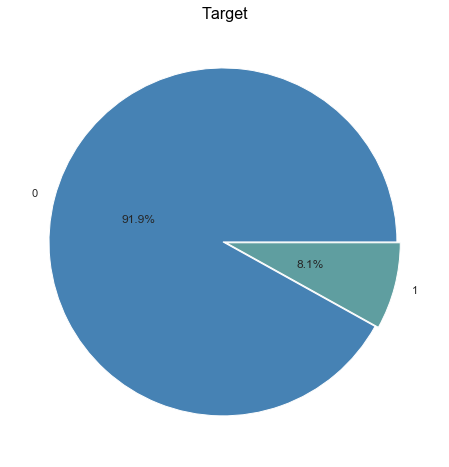

In [29]:
subset=data_train.groupby('TARGET')['TARGET'].count()
subset=subset.sort_values(ascending=False)

pie, ax = plt.subplots(figsize=[8,8])
sns.set(font_scale=1)
labels = subset.index
plt.pie(x=subset, autopct="%.1f%%", explode=[0.01]*2, labels=labels, pctdistance=0.5,colors = ['steelblue','#5F9EA0','thistle', 'cornflowerblue','y'])
plt.title("Target", fontsize=16)

subset

In [30]:
print('Data train :')
print('CODE_GENDER values : ', data_train.CODE_GENDER.unique()) #(male or female or XNA)
print('FLAG_OWN_CAR values : ', data_train.FLAG_OWN_CAR.unique()) #(yes or no)
print('FLAG_OWN_REALTY values : ', data_train.FLAG_OWN_REALTY.unique()) #(yes or no)
print('Number of rows with CODE_GENDER =XNA : ' , len(data_train[data_train.CODE_GENDER=='XNA']))
# outliers 365243
print('DAYS_EMPLOYED values : ', data_train.sort_values(by='DAYS_EMPLOYED')['DAYS_EMPLOYED'].unique()) 

print('\nData test :')
print('CODE_GENDER values : ', data_test.CODE_GENDER.unique()) #(male or female or XNA)
print('FLAG_OWN_CAR values : ', data_test.FLAG_OWN_CAR.unique()) #(yes or no)
print('FLAG_OWN_REALTY values : ', data_test.FLAG_OWN_REALTY.unique()) #(yes or no)
# outliers 365243
print('DAYS_EMPLOYED values : ', data_test.sort_values(by='DAYS_EMPLOYED')['DAYS_EMPLOYED'].unique()) 

Data train :
CODE_GENDER values :  ['M' 'F' 'XNA']
FLAG_OWN_CAR values :  ['N' 'Y']
FLAG_OWN_REALTY values :  ['Y' 'N']
Number of rows with CODE_GENDER =XNA :  4
DAYS_EMPLOYED values :  [-17912 -17583 -17546 ...     -1      0 365243]

Data test :
CODE_GENDER values :  ['F' 'M']
FLAG_OWN_CAR values :  ['N' 'Y']
FLAG_OWN_REALTY values :  ['Y' 'N']
DAYS_EMPLOYED values :  [-17463 -17124 -17077 ...     -5     -1 365243]


<font color='red'>**Preprocess application_train.csv and application_test.csv**</font>

* Merge application_train et application_test
* Suppression des 4 applications avec CODE_GENDER = XNA (train set)
* Codage binaire des features catégorielles 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY'
* One-Hot encode des features catégorielles (16 features)
* Imputation des Valeurs 365243 par NaN pour 'DAYS_EMPLOYED'
* Ajout des colonnes : 'DAYS_EMPLOYED_PERC', 'INCOME_CREDIT_PERC', 'INCOME_PER_PERSON', 'ANNUITY_INCOME_PERC', 'PAYMENT_RATE'

In [31]:
# Preprocess application_train.csv and application_test.csv
def application_train_test(train_df, test_df, nan_as_category = False):
    # Read data and merge
    print("Train samples: {}, test samples: {}".format(len(train_df), len(test_df)))
    df = train_df.append(test_df).reset_index()
    
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    
    return df

In [32]:
data_train_test= application_train_test(data_train, data_test, nan_as_category = False)

Train samples: 307511, test samples: 48744


In [33]:
print(data_train_test.shape)
print(data_train_test.columns)
print('\n Pourcentage des données manquantes par colonne dans data: \n', data_train_test.isnull().mean()*100)
data_train_test.head(2)

(356251, 248)
Index(['index', 'SK_ID_CURR', 'TARGET', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY',
       ...
       'WALLSMATERIAL_MODE_Panel', 'WALLSMATERIAL_MODE_Stone, brick',
       'WALLSMATERIAL_MODE_Wooden', 'EMERGENCYSTATE_MODE_No',
       'EMERGENCYSTATE_MODE_Yes', 'DAYS_EMPLOYED_PERC', 'INCOME_CREDIT_PERC',
       'INCOME_PER_PERSON', 'ANNUITY_INCOME_PERC', 'PAYMENT_RATE'],
      dtype='object', length=248)

 Pourcentage des données manquantes par colonne dans data: 
 index                   0.000000
SK_ID_CURR              0.000000
TARGET                 13.682488
CODE_GENDER             0.000000
FLAG_OWN_CAR            0.000000
                         ...    
DAYS_EMPLOYED_PERC     18.146756
INCOME_CREDIT_PERC      0.000000
INCOME_PER_PERSON       0.000561
ANNUITY_INCOME_PERC     0.010105
PAYMENT_RATE            0.010105
Length: 248, dtype: float64


index  SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0      0      100002     1.0            0             0                0   
1      1      100003     0.0            1             0                1   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  ...  \
0             0          202500.0    406597.5      24700.5  ...   
1             0          270000.0   1293502.5      35698.5  ...   

   WALLSMATERIAL_MODE_Panel  WALLSMATERIAL_MODE_Stone, brick  \
0                         0                                1   
1                         0                                0   

   WALLSMATERIAL_MODE_Wooden  EMERGENCYSTATE_MODE_No  EMERGENCYSTATE_MODE_Yes  \
0                          0                       1                        0   
1                          0                       1                        0   

   DAYS_EMPLOYED_PERC  INCOME_CREDIT_PERC  INCOME_PER_PERSON  \
0            0.067329            0.498036           202500.0   
1            0.070862            0.208736           135000.0   

   ANNUITY_INCOME_PERC  PAYMENT_RATE  
0             0.121978      0.060749  
1             0.132217      0.027598  

[2 rows x 248 columns]

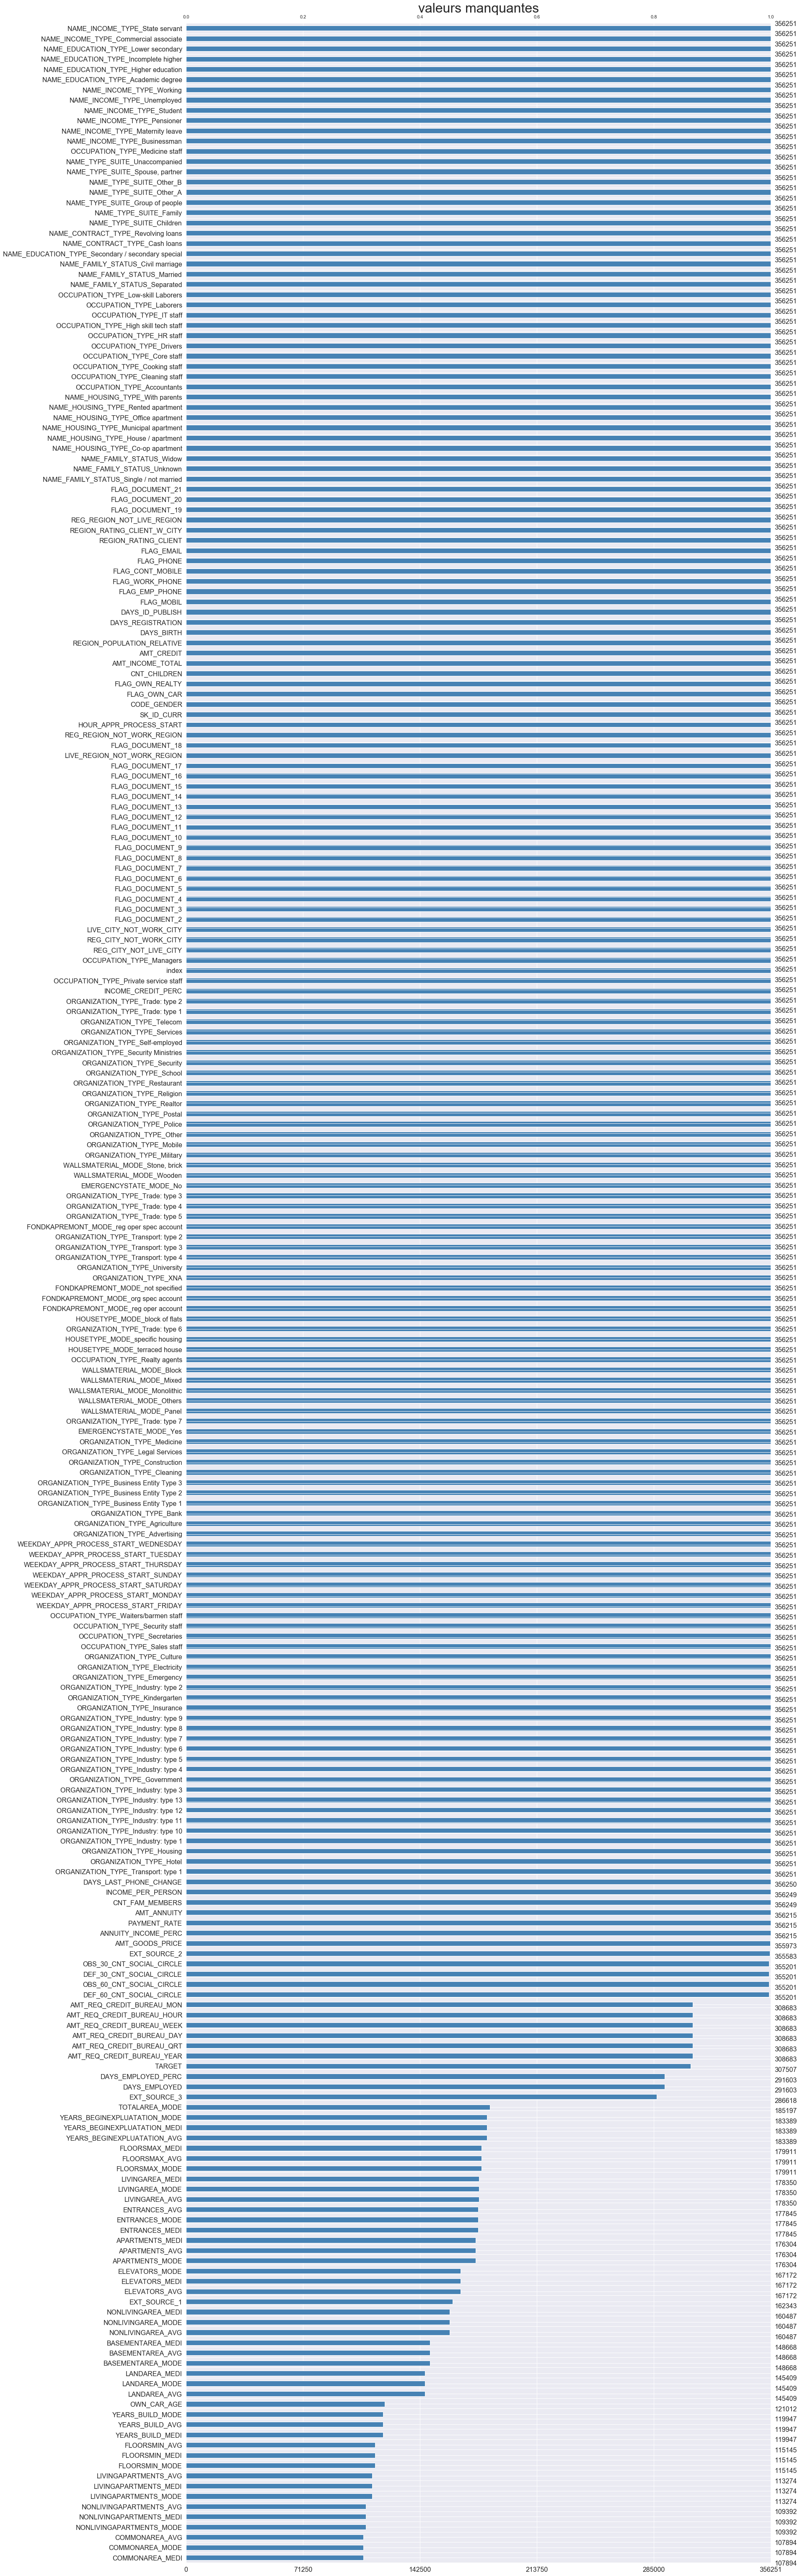

In [34]:
fig = plt.figure(figsize=(8,30))
msno.bar(data_train_test,  color="steelblue", sort="ascending")
plt.title('valeurs manquantes', size=32)
plt.show()

CODE_GENDER
1    235126
0    121125
Name: CODE_GENDER, dtype: int64

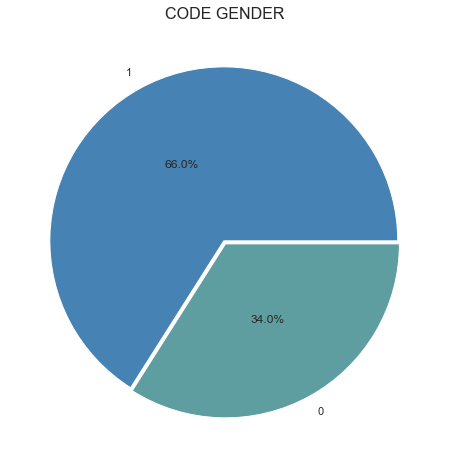

In [35]:
subset=data_train_test.groupby('CODE_GENDER')['CODE_GENDER'].count()
subset=subset.sort_values(ascending=False)

pie, ax = plt.subplots(figsize=[8,8])
sns.set(font_scale=1)
labels = subset.index
plt.pie(x=subset, autopct="%.1f%%", explode=[0.01]*2, labels=labels, pctdistance=0.5,colors = ['steelblue','#5F9EA0','thistle', 'cornflowerblue','y'])
plt.title("CODE GENDER", fontsize=16)

subset

## Bureau et bureau_balance

<font color='red'>**bureau.CSV**</font>

In [36]:
bureau=pd.read_csv("D:/FORMATION_DataScientist/projet_7/data/bureau.CSV")
print(bureau.shape)
print(bureau.columns)
print('\n Pourcentage des données manquantes par colonne dans bureau: \n', bureau.isnull().mean()*100)
bureau.head(2)

(1716428, 17)
Index(['SK_ID_CURR', 'SK_ID_BUREAU', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY',
       'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE',
       'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG',
       'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT',
       'AMT_CREDIT_SUM_OVERDUE', 'CREDIT_TYPE', 'DAYS_CREDIT_UPDATE',
       'AMT_ANNUITY'],
      dtype='object')

 Pourcentage des données manquantes par colonne dans bureau: 
 SK_ID_CURR                 0.000000
SK_ID_BUREAU               0.000000
CREDIT_ACTIVE              0.000000
CREDIT_CURRENCY            0.000000
DAYS_CREDIT                0.000000
CREDIT_DAY_OVERDUE         0.000000
DAYS_CREDIT_ENDDATE        6.149573
DAYS_ENDDATE_FACT         36.916958
AMT_CREDIT_MAX_OVERDUE    65.513264
CNT_CREDIT_PROLONG         0.000000
AMT_CREDIT_SUM             0.000757
AMT_CREDIT_SUM_DEBT       15.011932
AMT_CREDIT_SUM_LIMIT      34.477415
AMT_CREDIT_SUM_OVERDUE     0.000000
CREDIT_TYPE    

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN

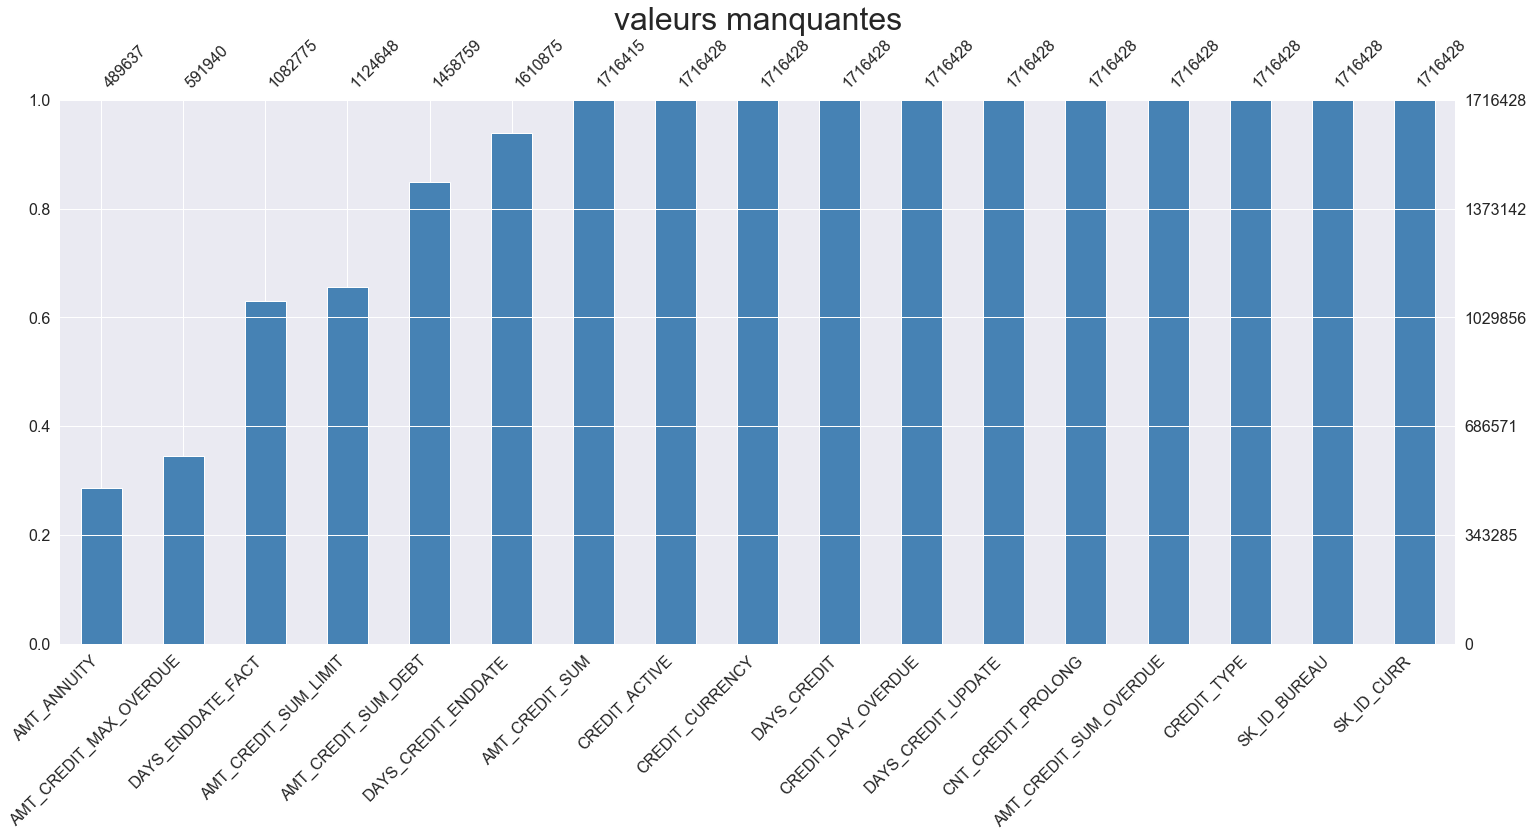

In [37]:
fig = plt.figure(figsize=(8,20))
msno.bar(bureau,  color="steelblue", sort="ascending")
plt.title('valeurs manquantes', size=32)
plt.show()

In [38]:
print('Number of non-categorical features :', bureau.describe().shape[1], '\n')

col= bureau.describe().columns
for col_ in col:
    print('\nDescription of features "', col_, '" :',HomeCredit_columns_description[HomeCredit_columns_description.Row==col_]['Description'].values)
    print('\n', len(bureau[col_].unique()), 'values :', bureau.sort_values(by=col_)[col_].unique())
    print('\n---------------------------------------------------------------------------------------------------')

bureau.describe()

Number of non-categorical features : 14 


Description of features " SK_ID_CURR " : ['ID of loan in our sample'
 'ID of loan in our sample - one loan in our sample can have 0,1,2 or more related previous credits in credit bureau '
 'ID of loan in our sample' 'ID of loan in our sample'
 'ID of loan in our sample' 'ID of loan in our sample']

 305811 values : [100001 100002 100003 ... 456253 456254 456255]

---------------------------------------------------------------------------------------------------

Description of features " SK_ID_BUREAU " : []

 1716428 values : [5000000 5000001 5000002 ... 6843455 6843456 6843457]

---------------------------------------------------------------------------------------------------

Description of features " DAYS_CREDIT " : ['How many days before current application did client apply for Credit Bureau credit']

 2923 values : [-2922 -2921 -2920 ...    -2    -1     0]

---------------------------------------------------------------------------------


 1616 values : [0.000000e+00 4.500000e-02 2.700000e-01 ... 2.387232e+06 3.681063e+06
 3.756681e+06]

---------------------------------------------------------------------------------------------------

Description of features " DAYS_CREDIT_UPDATE " : ['How many days before loan application did last information about the Credit Bureau credit come']

 2982 values : [-41947 -41946 -41945 ...     22     23    372]

---------------------------------------------------------------------------------------------------

Description of features " AMT_ANNUITY " : ['Loan annuity' 'Annuity of the Credit Bureau credit'
 'Annuity of previous application']

 40322 values : [0.00000000e+00 4.50000000e-02 3.15000000e-01 ... 9.06323715e+07
 1.18453424e+08            nan]

---------------------------------------------------------------------------------------------------


SK_ID_CURR  SK_ID_BUREAU   DAYS_CREDIT  CREDIT_DAY_OVERDUE  \
count  1.716428e+06  1.716428e+06  1.716428e+06        1.716428e+06   
mean   2.782149e+05  5.924434e+06 -1.142108e+03        8.181666e-01   
std    1.029386e+05  5.322657e+05  7.951649e+02        3.654443e+01   
min    1.000010e+05  5.000000e+06 -2.922000e+03        0.000000e+00   
25%    1.888668e+05  5.463954e+06 -1.666000e+03        0.000000e+00   
50%    2.780550e+05  5.926304e+06 -9.870000e+02        0.000000e+00   
75%    3.674260e+05  6.385681e+06 -4.740000e+02        0.000000e+00   
max    4.562550e+05  6.843457e+06  0.000000e+00        2.792000e+03   

       DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  AMT_CREDIT_MAX_OVERDUE  \
count         1.610875e+06       1.082775e+06            5.919400e+05   
mean          5.105174e+02      -1.017437e+03            3.825418e+03   
std           4.994220e+03       7.140106e+02            2.060316e+05   
min          -4.206000e+04      -4.202300e+04            0.000000e+00   
25%          -1.138000e+03      -1.489000e+03            0.000000e+00   
50%          -3.300000e+02      -8.970000e+02            0.000000e+00   
75%           4.740000e+02      -4.250000e+02            0.000000e+00   
max           3.119900e+04       0.000000e+00            1.159872e+08   

       CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  AMT_CREDIT_SUM_DEBT  \
count        1.716428e+06    1.716415e+06         1.458759e+06   
mean         6.410406e-03    3.549946e+05         1.370851e+05   
std          9.622391e-02    1.149811e+06         6.774011e+05   
min          0.000000e+00    0.000000e+00        -4.705600e+06   
25%          0.000000e+00    5.130000e+04         0.000000e+00   
50%          0.000000e+00    1.255185e+05         0.000000e+00   
75%          0.000000e+00    3.150000e+05         4.015350e+04   
max          9.000000e+00    5.850000e+08         1.701000e+08   

       AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  DAYS_CREDIT_UPDATE  \
count          1.124648e+06            1.716428e+06        1.716428e+06   
mean           6.229515e+03            3.791276e+01       -5.937483e+02   
std            4.503203e+04            5.937650e+03        7.207473e+02   
min           -5.864061e+05            0.000000e+00       -4.194700e+04   
25%            0.000000e+00            0.000000e+00       -9.080000e+02   
50%            0.000000e+00            0.000000e+00       -3.950000e+02   
75%            0.000000e+00            0.000000e+00       -3.300000e+01   
max            4.705600e+06            3.756681e+06        3.720000e+02   

        AMT_ANNUITY  
count  4.896370e+05  
mean   1.571276e+04  
std    3.258269e+05  
min    0.000000e+00  
25%    0.000000e+00  
50%    0.000000e+00  
75%    1.350000e+04  
max    1.184534e+08

In [39]:
print('Number of categorical features :', bureau.describe(include='object').shape[1], '\n')

col= bureau.describe(include='object').columns
for col_ in col:
    print('\n* Feature "', col_, '" :')
    print('-------------------------------')
    print('Description of features :',HomeCredit_columns_description[HomeCredit_columns_description.Row==col_]['Description'].values)
    print('\n', len(bureau[col_].unique()), 'values :', bureau[col_].unique())
    print('\n---------------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------------')

bureau.describe(include='object')

Number of categorical features : 3 


* Feature " CREDIT_ACTIVE " :
-------------------------------
Description of features : ['Status of the Credit Bureau (CB) reported credits']

 4 values : ['Closed' 'Active' 'Sold' 'Bad debt']

---------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------

* Feature " CREDIT_CURRENCY " :
-------------------------------
Description of features : ['Recoded currency of the Credit Bureau credit']

 4 values : ['currency 1' 'currency 2' 'currency 4' 'currency 3']

---------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------

* Feature " CREDIT_TYPE " :
-------------------------------
Description of features : ['Type of Credit Bureau credit (Car, cash,...)']

 15 values : ['Consumer

CREDIT_ACTIVE CREDIT_CURRENCY      CREDIT_TYPE
count        1716428         1716428          1716428
unique             4               4               15
top           Closed      currency 1  Consumer credit
freq         1079273         1715020          1251615

CREDIT_TYPE
Consumer credit                                 1251615
Credit card                                      402195
Car loan                                          27690
Mortgage                                          18391
Microloan                                         12413
Loan for business development                      1975
Another type of loan                               1017
Unknown type of loan                                555
Loan for working capital replenishment              469
Cash loan (non-earmarked)                            56
Real estate loan                                     27
Loan for the purchase of equipment                   19
Loan for purchase of shares (margin lending)          4
Interbank credit                                      1
Mobile operator loan                                  1
Name: CREDIT_TYPE, dtype: int64

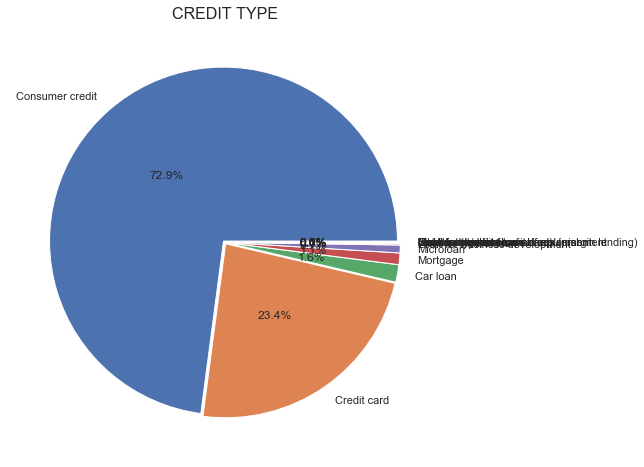

In [40]:
subset=bureau.groupby('CREDIT_TYPE')['CREDIT_TYPE'].count()
subset=subset.sort_values(ascending=False)

pie, ax = plt.subplots(figsize=[8,8])
sns.set(font_scale=1)
labels = subset.index
plt.pie(x=subset, autopct="%.1f%%", explode=[0.01]*15, labels=labels, pctdistance=0.5)
plt.title("CREDIT TYPE", fontsize=16)

subset

<font color='red'>**bureau_balance.CSV**</font>

In [41]:
bureau_balance=pd.read_csv("D:/FORMATION_DataScientist/projet_7/data/bureau_balance.CSV")
print(bureau_balance.shape)
print(bureau_balance.columns)
print('\n Pourcentage des données manquantes par colonne dans bureau: \n', bureau_balance.isnull().mean()*100)
bureau_balance.head(2)

(27299925, 3)
Index(['SK_ID_BUREAU', 'MONTHS_BALANCE', 'STATUS'], dtype='object')

 Pourcentage des données manquantes par colonne dans bureau: 
 SK_ID_BUREAU      0.0
MONTHS_BALANCE    0.0
STATUS            0.0
dtype: float64


SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C
1       5715448              -1      C

In [42]:
print('Number of non-categorical features :', bureau_balance.describe().shape[1], '\n')

col= bureau_balance.describe().columns
for col_ in col:
    print('\nDescription of features "', col_, '" :',HomeCredit_columns_description[HomeCredit_columns_description.Row==col_]['Description'].values)
    print('\n', len(bureau_balance[col_].unique()), 'values :', bureau_balance.sort_values(by=col_)[col_].unique())
    print('\n---------------------------------------------------------------------------------------------------')

bureau_balance.describe()

Number of non-categorical features : 2 


Description of features " SK_ID_BUREAU " : []

 817395 values : [5001709 5001710 5001711 ... 6842886 6842887 6842888]

---------------------------------------------------------------------------------------------------

Description of features " MONTHS_BALANCE " : ['Month of balance relative to application date (-1 means the freshest balance date)'
 'Month of balance relative to application date (-1 means the information to the freshest monthly snapshot, 0 means the information at application - often it will be the same as -1 as many banks are not updating the information to Credit Bureau regularly )'
 'Month of balance relative to application date (-1 means the freshest balance date)']

 97 values : [-96 -95 -94 -93 -92 -91 -90 -89 -88 -87 -86 -85 -84 -83 -82 -81 -80 -79
 -78 -77 -76 -75 -74 -73 -72 -71 -70 -69 -68 -67 -66 -65 -64 -63 -62 -61
 -60 -59 -58 -57 -56 -55 -54 -53 -52 -51 -50 -49 -48 -47 -46 -45 -44 -43
 -42 -41 -40 -39 -38 -37 -36 

SK_ID_BUREAU  MONTHS_BALANCE
count  2.729992e+07    2.729992e+07
mean   6.036297e+06   -3.074169e+01
std    4.923489e+05    2.386451e+01
min    5.001709e+06   -9.600000e+01
25%    5.730933e+06   -4.600000e+01
50%    6.070821e+06   -2.500000e+01
75%    6.431951e+06   -1.100000e+01
max    6.842888e+06    0.000000e+00

In [43]:
print('Number of categorical features :', bureau_balance.describe(include='object').shape[1], '\n')

col= bureau_balance.describe(include='object').columns
for col_ in col:
    print('\n* Feature "', col_, '" :')
    print('-------------------------------')
    print('Description of features :',HomeCredit_columns_description[HomeCredit_columns_description.Row==col_]['Description'].values)
    print('\n', len(bureau_balance[col_].unique()), 'values :', bureau_balance[col_].unique())
    print('\n---------------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------------')

bureau_balance.describe(include='object')

Number of categorical features : 1 


* Feature " STATUS " :
-------------------------------
Description of features : ['Status of Credit Bureau loan during the month (active, closed, DPD0-30,\x85 [C means closed, X means status unknown, 0 means no DPD, 1 means maximal did during month between 1-30, 2 means DPD 31-60,\x85 5 means DPD 120+ or sold or written off ] )']

 8 values : ['C' '0' 'X' '1' '2' '3' '5' '4']

---------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------


STATUS
count   27299925
unique         8
top            C
freq    13646993

<font color='red'>**Preprocess bureau.csv and bureau_balance.csv**</font>

* One-Hot encode des features catégorielles du bureau.CSV (3 features)
* One-Hot encode des features catégorielles du bureau_balance.CSV (1 feature)
* bureau_balance : Groupby SK_ID_BUREAU, Aggregation on MONTHS_BALANCE (min, max, size), Aggregation on STATUS (mean), jointure à gauche avec bureau.CSV (on SK_ID_BUREAU) -----> **dataframe bureau**
* bureau : Groupby  SK_ID_CURR, Aggregation on numeric features ('min', 'max', 'mean', 'var', 'sum), Aggregation on categorical features (mean) -----> **dataframe bureau_agg**
* Active (bureau with CREDIT_ACTIVE=active) : Groupby  SK_ID_CURR, Aggregation on numeric features only ('min', 'max', 'mean', 'var', 'sum), jointure à gauche avec bureau_agg (on SK_ID_CURR) 
* Closed (bureau with CREDIT_ACTIVE=closed) : Groupby  SK_ID_CURR, Aggregation on numeric features only ('min', 'max', 'mean', 'var', 'sum), jointure à gauche avec bureau_agg (on SK_ID_CURR)

--------> **dataframe bureau_agg** (305811 rows × 116 columns)

In [44]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(bureau, bb, nan_as_category = True):
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

In [45]:
bureau_agg = bureau_and_balance(bureau, bureau_balance, nan_as_category = True)

In [46]:
print(bureau_agg.shape)
print(bureau_agg.columns)
print('\n Pourcentage des données manquantes par colonne dans data: \n', bureau_agg.isnull().mean()*100)
bureau_agg.head(2)

(305811, 116)
Index(['BURO_DAYS_CREDIT_MIN', 'BURO_DAYS_CREDIT_MAX', 'BURO_DAYS_CREDIT_MEAN',
       'BURO_DAYS_CREDIT_VAR', 'BURO_DAYS_CREDIT_ENDDATE_MIN',
       'BURO_DAYS_CREDIT_ENDDATE_MAX', 'BURO_DAYS_CREDIT_ENDDATE_MEAN',
       'BURO_DAYS_CREDIT_UPDATE_MEAN', 'BURO_CREDIT_DAY_OVERDUE_MAX',
       'BURO_CREDIT_DAY_OVERDUE_MEAN',
       ...
       'CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN',
       'CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN', 'CLOSED_AMT_CREDIT_SUM_LIMIT_SUM',
       'CLOSED_AMT_ANNUITY_MAX', 'CLOSED_AMT_ANNUITY_MEAN',
       'CLOSED_CNT_CREDIT_PROLONG_SUM', 'CLOSED_MONTHS_BALANCE_MIN_MIN',
       'CLOSED_MONTHS_BALANCE_MAX_MAX', 'CLOSED_MONTHS_BALANCE_SIZE_MEAN',
       'CLOSED_MONTHS_BALANCE_SIZE_SUM'],
      dtype='object', length=116)

 Pourcentage des données manquantes par colonne dans data: 
 BURO_DAYS_CREDIT_MIN                0.000000
BURO_DAYS_CREDIT_MAX                0.000000
BURO_DAYS_CREDIT_MEAN               0.000000
BURO_DAYS_CREDIT_VAR               13.577013
BU

BURO_DAYS_CREDIT_MIN  BURO_DAYS_CREDIT_MAX  BURO_DAYS_CREDIT_MEAN  \
SK_ID_CURR                                                                      
100001                     -1572                   -49                 -735.0   
100002                     -1437                  -103                 -874.0   

            BURO_DAYS_CREDIT_VAR  BURO_DAYS_CREDIT_ENDDATE_MIN  \
SK_ID_CURR                                                       
100001             240043.666667                       -1329.0   
100002             186150.000000                       -1072.0   

            BURO_DAYS_CREDIT_ENDDATE_MAX  BURO_DAYS_CREDIT_ENDDATE_MEAN  \
SK_ID_CURR                                                                
100001                            1778.0                      82.428571   
100002                             780.0                    -349.000000   

            BURO_DAYS_CREDIT_UPDATE_MEAN  BURO_CREDIT_DAY_OVERDUE_MAX  \
SK_ID_CURR                                                              
100001                        -93.142857                            0   
100002                       -499.875000                            0   

            BURO_CREDIT_DAY_OVERDUE_MEAN  ...  \
SK_ID_CURR                                ...   
100001                               0.0  ...   
100002                               0.0  ...   

            CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN  \
SK_ID_CURR                                       
100001                                     0.0   
100002                                     0.0   

            CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN  CLOSED_AMT_CREDIT_SUM_LIMIT_SUM  \
SK_ID_CURR                                                                      
100001                                   0.0                              0.0   
100002                                   0.0                              0.0   

            CLOSED_AMT_ANNUITY_MAX  CLOSED_AMT_ANNUITY_MEAN  \
SK_ID_CURR                                                    
100001                         0.0                      0.0   
100002                         0.0                      0.0   

            CLOSED_CNT_CREDIT_PROLONG_SUM  CLOSED_MONTHS_BALANCE_MIN_MIN  \
SK_ID_CURR                                                                 
100001                                0.0                          -51.0   
100002                                0.0                          -47.0   

            CLOSED_MONTHS_BALANCE_MAX_MAX  CLOSED_MONTHS_BALANCE_SIZE_MEAN  \
SK_ID_CURR                                                                   
100001                                0.0                             35.0   
100002                                0.0                             15.0   

            CLOSED_MONTHS_BALANCE_SIZE_SUM  
SK_ID_CURR                                  
100001                               140.0  
100002                                90.0  

[2 rows x 116 columns]

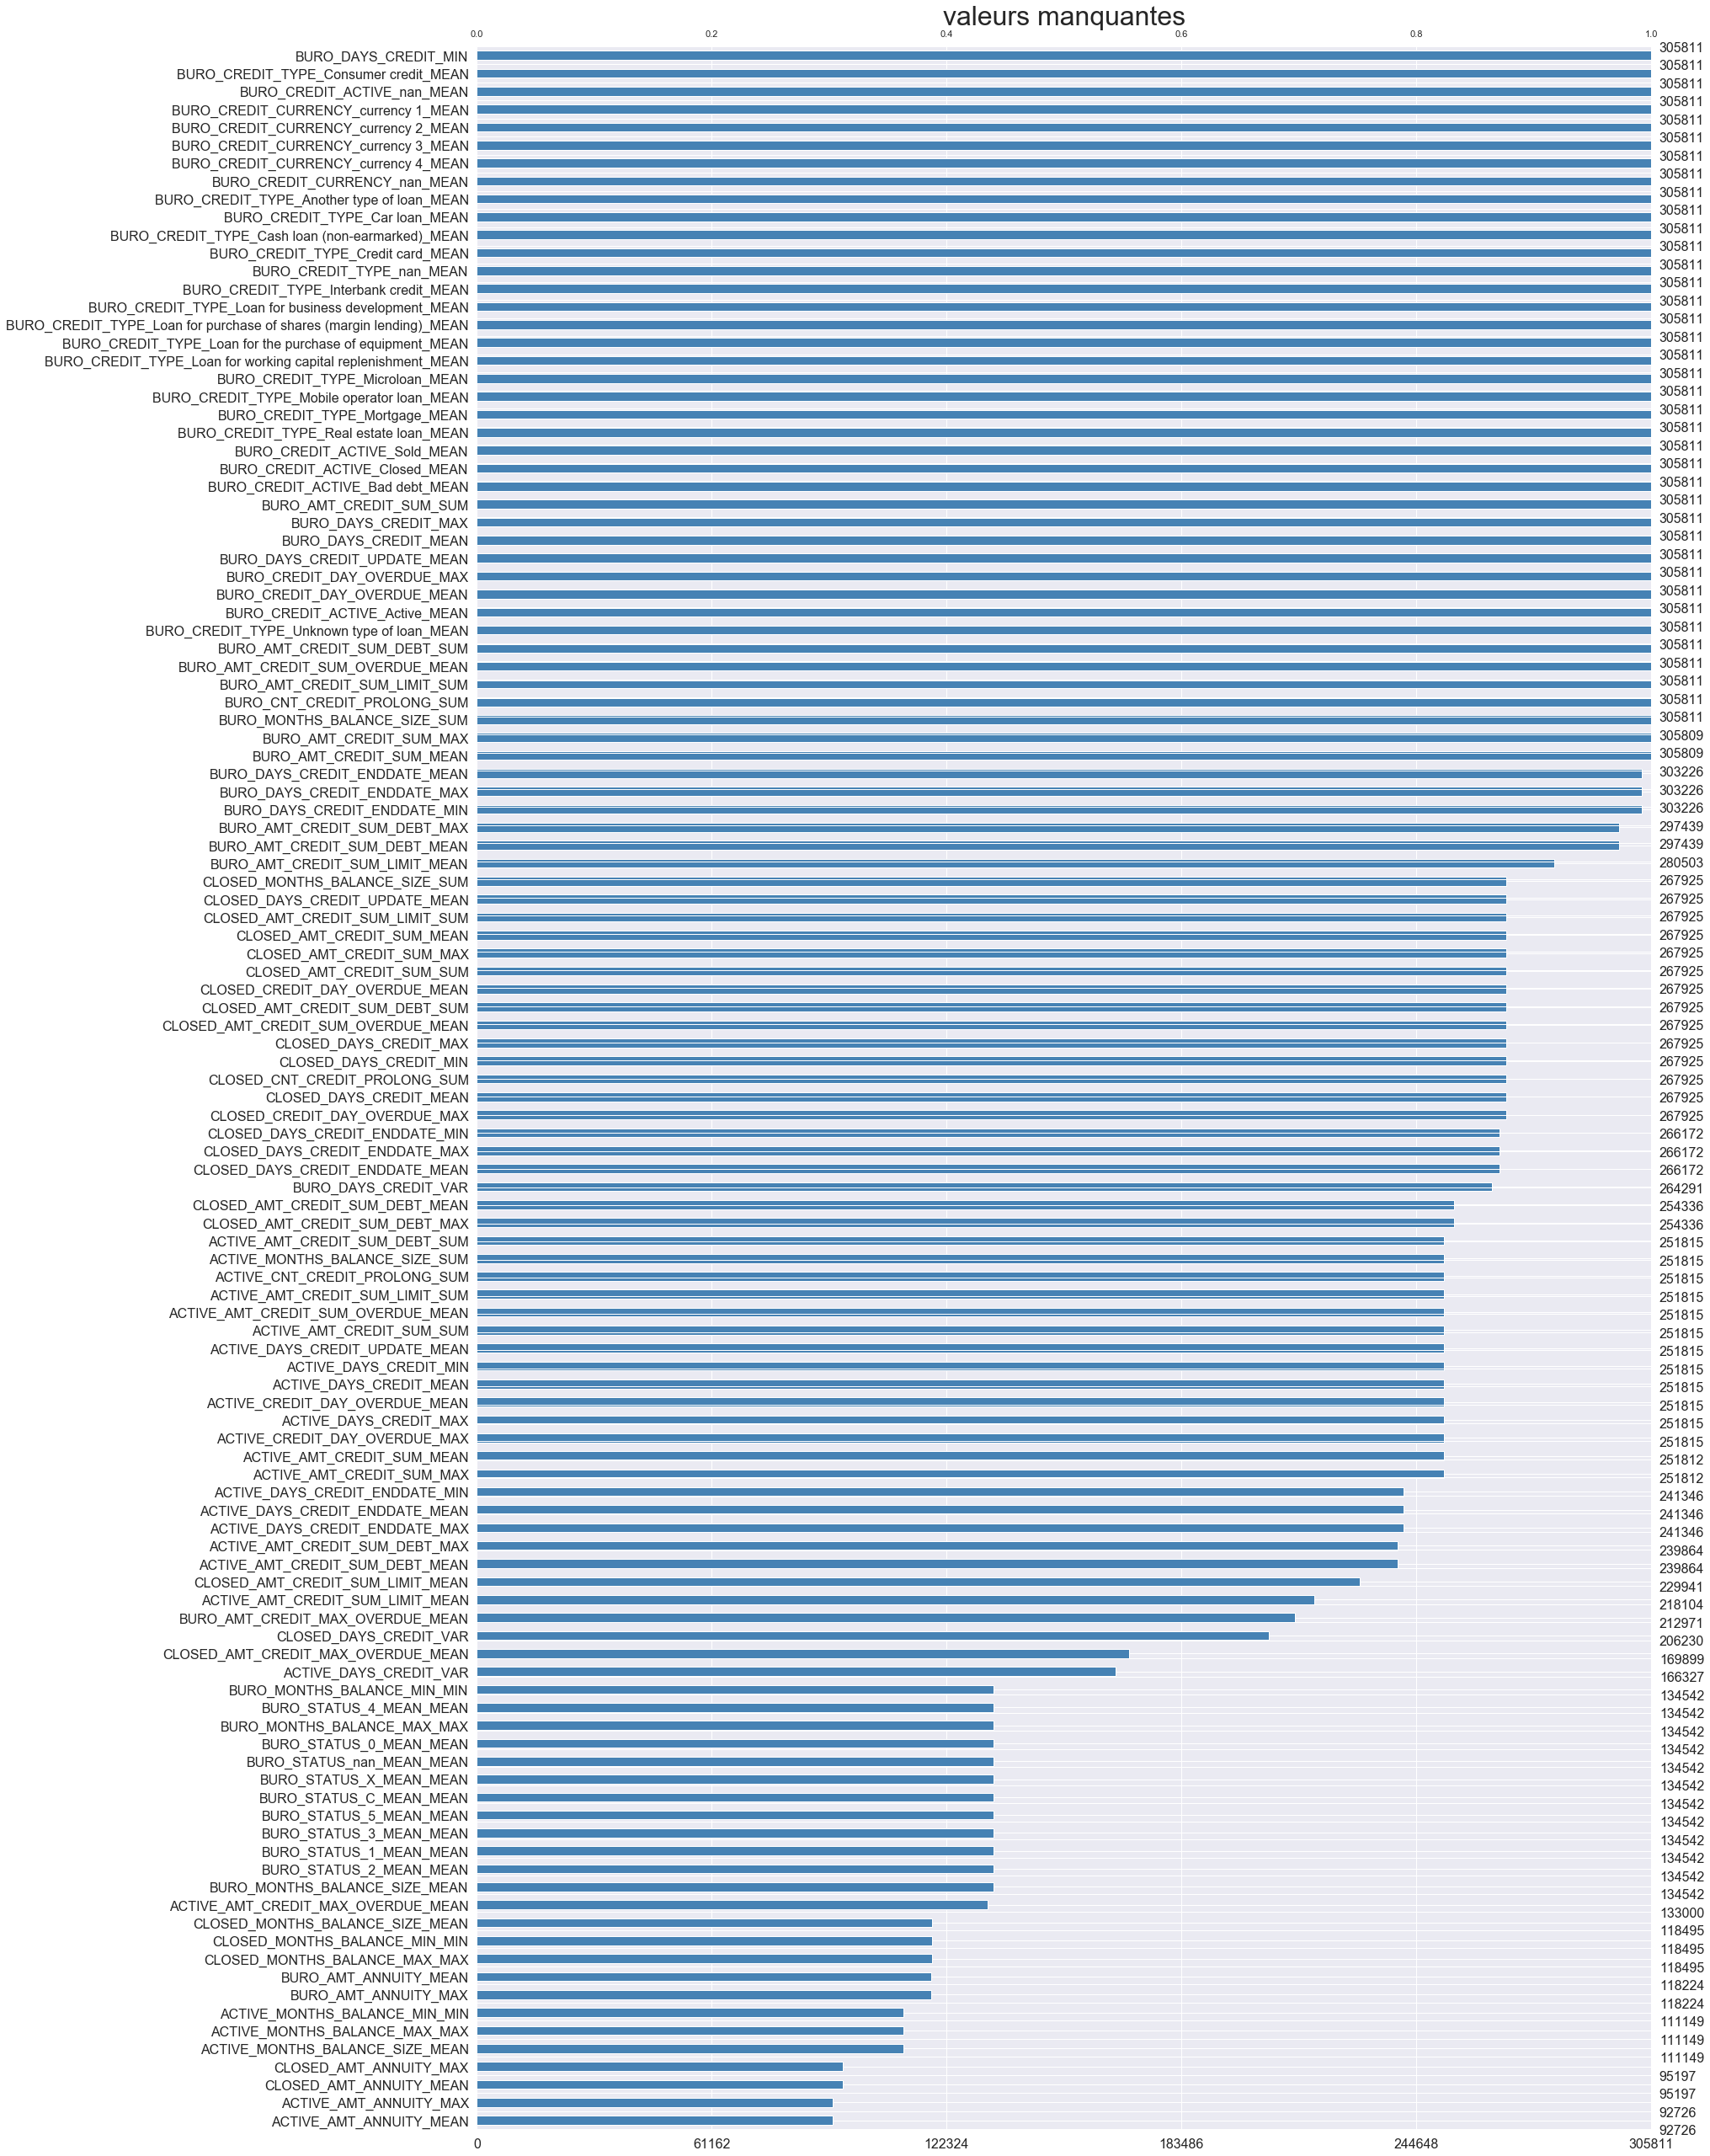

In [47]:
fig = plt.figure(figsize=(8,30))
msno.bar(bureau_agg,  color="steelblue", sort="ascending")
plt.title('valeurs manquantes', size=32)
plt.show()

## Previous application

<font color='red'>**previous_applications.csv**</font>

In [48]:
previous_application=pd.read_csv("D:/FORMATION_DataScientist/projet_7/data/previous_application.CSV")
print(previous_application.shape)
print(previous_application.columns)
print('\n Pourcentage des données manquantes par colonne dans bureau: \n', previous_application.isnull().mean()*100)
previous_application.head(2)

(1670214, 37)
Index(['SK_ID_PREV', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'AMT_ANNUITY',
       'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE',
       'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'FLAG_LAST_APPL_PER_CONTRACT', 'NFLAG_LAST_APPL_IN_DAY',
       'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY',
       'RATE_INTEREST_PRIVILEGED', 'NAME_CASH_LOAN_PURPOSE',
       'NAME_CONTRACT_STATUS', 'DAYS_DECISION', 'NAME_PAYMENT_TYPE',
       'CODE_REJECT_REASON', 'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE',
       'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE',
       'CHANNEL_TYPE', 'SELLERPLACE_AREA', 'NAME_SELLER_INDUSTRY',
       'CNT_PAYMENT', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION',
       'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION',
       'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL'],
      dtype='object')

 Pourcentage des données manquantes par colonne dans bureau: 
 SK_ID_PREV         

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START  ... NAME_SELLER_INDUSTRY  CNT_PAYMENT  \
0                       15  ...         Connectivity         12.0   
1                       11  ...                  XNA         36.0   

   NAME_YIELD_GROUP       PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0            middle  POS mobile with interest            365243.0   
1        low_action          Cash X-Sell: low            365243.0   

  DAYS_FIRST_DUE DAYS_LAST_DUE_1ST_VERSION  DAYS_LAST_DUE DAYS_TERMINATION  \
0          -42.0                     300.0          -42.0            -37.0   
1         -134.0                     916.0       365243.0         365243.0   

  NFLAG_INSURED_ON_APPROVAL  
0                       0.0  
1                       1.0  

[2 rows x 37 columns]

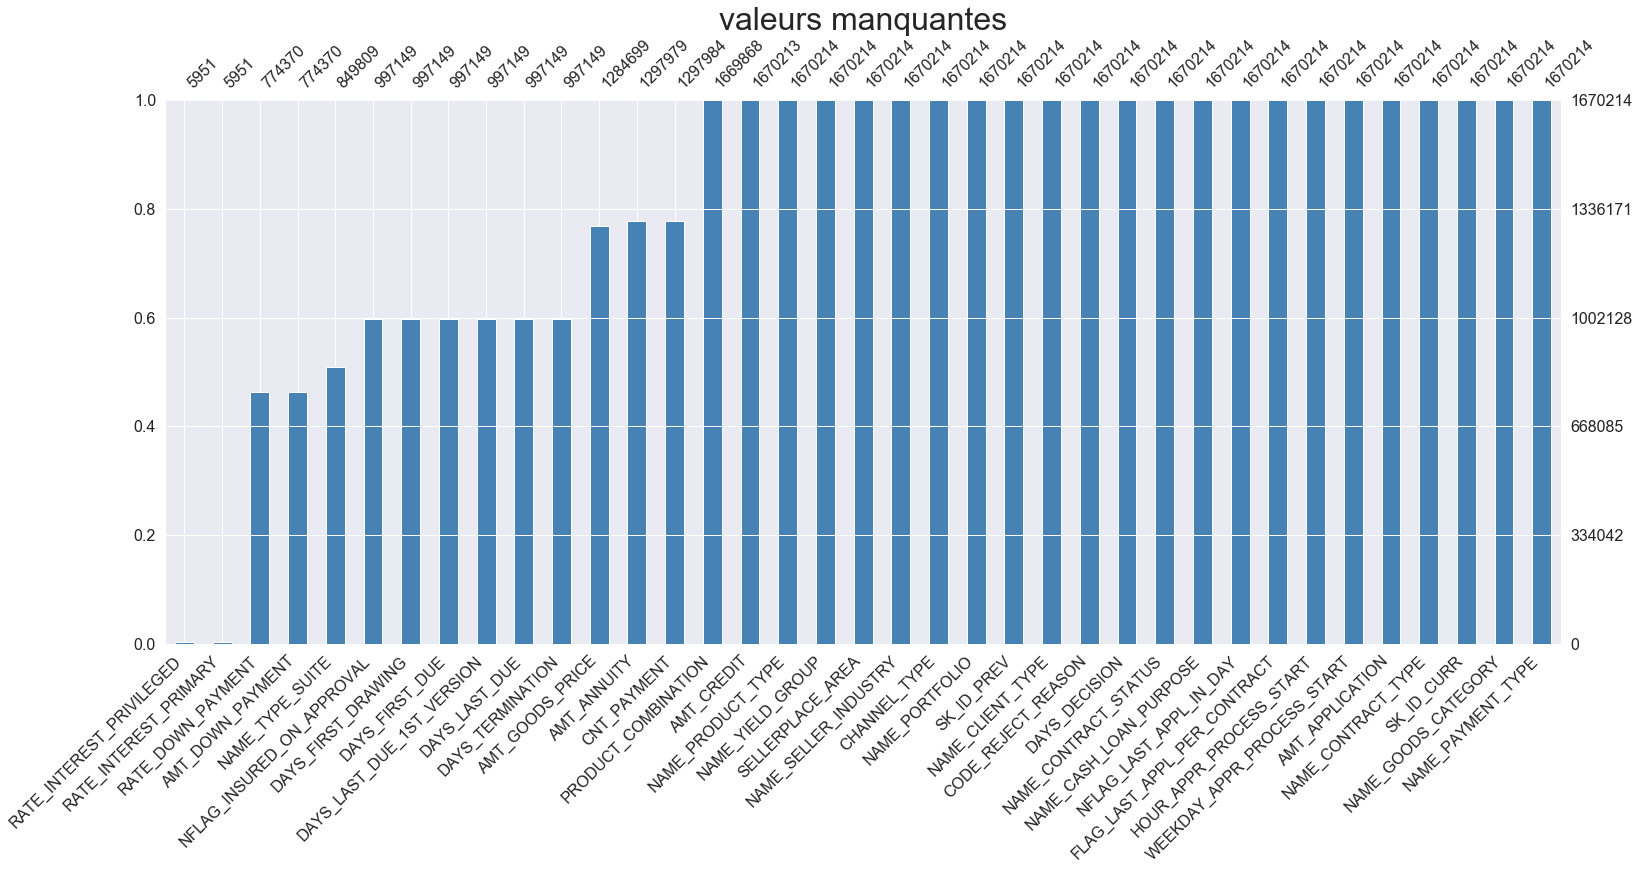

In [49]:
fig = plt.figure(figsize=(8,20))
msno.bar(previous_application,  color="steelblue", sort="ascending")
plt.title('valeurs manquantes', size=32)
plt.show()

In [50]:
print('Number of non-categorical features :', previous_application.describe().shape[1], '\n')

col= previous_application.describe().columns
for col_ in col:
    print('\nDescription of features "', col_, '" :',HomeCredit_columns_description[HomeCredit_columns_description.Row==col_]['Description'].values)
    print('\n', len(previous_application[col_].unique()), 'values :', previous_application.sort_values(by=col_)[col_].unique())
    print('\n---------------------------------------------------------------------------------------------------')

previous_application.describe()

Number of non-categorical features : 21 


Description of features " SK_ID_PREV " : []

 1670214 values : [1000001 1000002 1000003 ... 2845379 2845381 2845382]

---------------------------------------------------------------------------------------------------

Description of features " SK_ID_CURR " : ['ID of loan in our sample'
 'ID of loan in our sample - one loan in our sample can have 0,1,2 or more related previous credits in credit bureau '
 'ID of loan in our sample' 'ID of loan in our sample'
 'ID of loan in our sample' 'ID of loan in our sample']

 338857 values : [100001 100002 100003 ... 456253 456254 456255]

---------------------------------------------------------------------------------------------------

Description of features " AMT_ANNUITY " : ['Loan annuity' 'Annuity of the Credit Bureau credit'
 'Annuity of previous application']

 357960 values : [     0.       579.78     585.855 ... 417927.645 418058.145        nan]

------------------------------------------------


 2874 values : [-2.88900e+03 -2.88800e+03 -2.88500e+03 ... -2.00000e+00  3.65243e+05
          nan]

---------------------------------------------------------------------------------------------------

Description of features " DAYS_TERMINATION " : ['Relative to application date of current application when was the expected termination of the previous application']

 2831 values : [-2.87400e+03 -2.87000e+03 -2.86500e+03 ... -2.00000e+00  3.65243e+05
          nan]

---------------------------------------------------------------------------------------------------

Description of features " NFLAG_INSURED_ON_APPROVAL " : ['Did the client requested insurance during the previous application']

 3 values : [ 0.  1. nan]

---------------------------------------------------------------------------------------------------


SK_ID_PREV    SK_ID_CURR   AMT_ANNUITY  AMT_APPLICATION  \
count  1.670214e+06  1.670214e+06  1.297979e+06     1.670214e+06   
mean   1.923089e+06  2.783572e+05  1.595512e+04     1.752339e+05   
std    5.325980e+05  1.028148e+05  1.478214e+04     2.927798e+05   
min    1.000001e+06  1.000010e+05  0.000000e+00     0.000000e+00   
25%    1.461857e+06  1.893290e+05  6.321780e+03     1.872000e+04   
50%    1.923110e+06  2.787145e+05  1.125000e+04     7.104600e+04   
75%    2.384280e+06  3.675140e+05  2.065842e+04     1.803600e+05   
max    2.845382e+06  4.562550e+05  4.180581e+05     6.905160e+06   

         AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE  \
count  1.670213e+06      7.743700e+05     1.284699e+06   
mean   1.961140e+05      6.697402e+03     2.278473e+05   
std    3.185746e+05      2.092150e+04     3.153966e+05   
min    0.000000e+00     -9.000000e-01     0.000000e+00   
25%    2.416050e+04      0.000000e+00     5.084100e+04   
50%    8.054100e+04      1.638000e+03     1.123200e+05   
75%    2.164185e+05      7.740000e+03     2.340000e+05   
max    6.905160e+06      3.060045e+06     6.905160e+06   

       HOUR_APPR_PROCESS_START  NFLAG_LAST_APPL_IN_DAY  RATE_DOWN_PAYMENT  \
count             1.670214e+06            1.670214e+06      774370.000000   
mean              1.248418e+01            9.964675e-01           0.079637   
std               3.334028e+00            5.932963e-02           0.107823   
min               0.000000e+00            0.000000e+00          -0.000015   
25%               1.000000e+01            1.000000e+00           0.000000   
50%               1.200000e+01            1.000000e+00           0.051605   
75%               1.500000e+01            1.000000e+00           0.108909   
max               2.300000e+01            1.000000e+00           1.000000   

       ...  RATE_INTEREST_PRIVILEGED  DAYS_DECISION  SELLERPLACE_AREA  \
count  ...               5951.000000   1.670214e+06      1.670214e+06   
mean   ...                  0.773503  -8.806797e+02      3.139511e+02   
std    ...                  0.100879   7.790997e+02      7.127443e+03   
min    ...                  0.373150  -2.922000e+03     -1.000000e+00   
25%    ...                  0.715645  -1.300000e+03     -1.000000e+00   
50%    ...                  0.835095  -5.810000e+02      3.000000e+00   
75%    ...                  0.852537  -2.800000e+02      8.200000e+01   
max    ...                  1.000000  -1.000000e+00      4.000000e+06   

        CNT_PAYMENT  DAYS_FIRST_DRAWING  DAYS_FIRST_DUE  \
count  1.297984e+06       997149.000000   997149.000000   
mean   1.605408e+01       342209.855039    13826.269337   
std    1.456729e+01        88916.115834    72444.869708   
min    0.000000e+00        -2922.000000    -2892.000000   
25%    6.000000e+00       365243.000000    -1628.000000   
50%    1.200000e+01       365243.000000     -831.000000   
75%    2.400000e+01       365243.000000     -411.000000   
max    8.400000e+01       365243.000000   365243.000000   

       DAYS_LAST_DUE_1ST_VERSION  DAYS_LAST_DUE  DAYS_TERMINATION  \
count              997149.000000  997149.000000     997149.000000   
mean                33767.774054   76582.403064      81992.343838   
std                106857.034789  149647.415123     153303.516729   
min                 -2801.000000   -2889.000000      -2874.000000   
25%                 -1242.000000   -1314.000000      -1270.000000   
50%                  -361.000000    -537.000000       -499.000000   
75%                   129.000000     -74.000000        -44.000000   
max                365243.000000  365243.000000     365243.000000   

       NFLAG_INSURED_ON_APPROVAL  
count              997149.000000  
mean                    0.332570  
std                     0.471134  
min                     0.000000  
25%                     0.000000  
50%                     0.000000  
75%                     1.000000  
max                     1.000000  

[8 rows x 21 columns]

In [51]:
print('Number of categorical features :', previous_application.describe(include='object').shape[1], '\n')

col= previous_application.describe(include='object').columns
for col_ in col:
    print('\n* Feature "', col_, '" :')
    print('-------------------------------')
    print('Description of features :',HomeCredit_columns_description[HomeCredit_columns_description.Row==col_]['Description'].values)
    print('\n', len(previous_application[col_].unique()), 'values :', previous_application[col_].unique())
    print('\n---------------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------------')
    
previous_application.describe(include='object')

Number of categorical features : 16 


* Feature " NAME_CONTRACT_TYPE " :
-------------------------------
Description of features : ['Identification if loan is cash or revolving'
 'Contract product type (Cash loan, consumer loan [POS] ,...) of the previous application']

 4 values : ['Consumer loans' 'Cash loans' 'Revolving loans' 'XNA']

---------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------

* Feature " WEEKDAY_APPR_PROCESS_START " :
-------------------------------
Description of features : ['On which day of the week did the client apply for the loan'
 'On which day of the week did the client apply for previous application']

 7 values : ['SATURDAY' 'THURSDAY' 'TUESDAY' 'MONDAY' 'FRIDAY' 'SUNDAY' 'WEDNESDAY']

---------------------------------------------------------------------------------------------------
---------------------------------

NAME_CONTRACT_TYPE WEEKDAY_APPR_PROCESS_START  \
count             1670214                    1670214   
unique                  4                          7   
top            Cash loans                    TUESDAY   
freq               747553                     255118   

       FLAG_LAST_APPL_PER_CONTRACT NAME_CASH_LOAN_PURPOSE  \
count                      1670214                1670214   
unique                           2                     25   
top                              Y                    XAP   
freq                       1661739                 922661   

       NAME_CONTRACT_STATUS      NAME_PAYMENT_TYPE CODE_REJECT_REASON  \
count               1670214                1670214            1670214   
unique                    4                      4                  9   
top                Approved  Cash through the bank                XAP   
freq                1036781                1033552            1353093   

       NAME_TYPE_SUITE NAME_CLIENT_TYPE NAME_GOODS_CATEGORY NAME_PORTFOLIO  \
count           849809          1670214             1670214        1670214   
unique               7                4                  28              5   
top      Unaccompanied         Repeater                 XNA            POS   
freq            508970          1231261              950809         691011   

       NAME_PRODUCT_TYPE             CHANNEL_TYPE NAME_SELLER_INDUSTRY  \
count            1670214                  1670214              1670214   
unique                 3                        8                   11   
top                  XNA  Credit and cash offices                  XNA   
freq             1063666                   719968               855720   

       NAME_YIELD_GROUP PRODUCT_COMBINATION  
count           1670214             1669868  
unique                5                  17  
top                 XNA                Cash  
freq             517215              285990

NAME_CONTRACT_STATUS
Approved        1036781
Canceled         316319
Refused          290678
Unused offer      26436
Name: NAME_CONTRACT_STATUS, dtype: int64

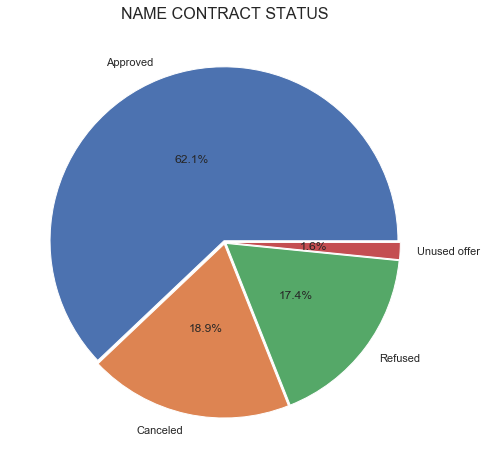

In [52]:
subset=previous_application.groupby('NAME_CONTRACT_STATUS')['NAME_CONTRACT_STATUS'].count()
subset=subset.sort_values(ascending=False)

pie, ax = plt.subplots(figsize=[8,8])
sns.set(font_scale=1)
labels = subset.index
plt.pie(x=subset, autopct="%.1f%%", explode=[0.01]*4, labels=labels, pctdistance=0.5)
plt.title("NAME CONTRACT STATUS", fontsize=16)

subset

<font color='red'>**Preprocess previous_applications.csv**</font>

* One-Hot encode des features catégorielles du previous_applications.CSV (16 features)
* Imputation : Days 365.243 values -> nan
* Add feature: value ask / value received percentage
* previous_application : Groupby SK_ID_CURR, Aggregation on numeric features ('min', 'max', 'mean', 'var', 'sum), Aggregation on categorical features (mean) -----> **dataframe prev_agg*
* approved (previous_application with NAME_CONTRACT_STATUS=approved) : Groupby SK_ID_CURR, Aggregation on numeric features only ('min', 'max', 'mean', 'var', 'sum), jointure à gauche avec prev_agg (on SK_ID_CURR) 
* refused (previous_application with NAME_CONTRACT_STATUS=refused) : Groupby SK_ID_CURR, Aggregation on numeric features only ('min', 'max', 'mean', 'var', 'sum), jointure à gauche avec prev_agg (on SK_ID_CURR)

--------> **dataframe prev_agg** (338857 rows × 249 columns)

In [53]:
# Preprocess previous_applications.csv
def previous_applications(prev, nan_as_category = True):
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

In [54]:
prev_agg = previous_applications(previous_application, nan_as_category = True)

In [55]:
print(prev_agg.shape)
print(prev_agg.columns)
print('\n Pourcentage des données manquantes par colonne dans data: \n', prev_agg.isnull().mean()*100)
prev_agg.head(2)

(338857, 249)
Index(['PREV_AMT_ANNUITY_MIN', 'PREV_AMT_ANNUITY_MAX', 'PREV_AMT_ANNUITY_MEAN',
       'PREV_AMT_APPLICATION_MIN', 'PREV_AMT_APPLICATION_MAX',
       'PREV_AMT_APPLICATION_MEAN', 'PREV_AMT_CREDIT_MIN',
       'PREV_AMT_CREDIT_MAX', 'PREV_AMT_CREDIT_MEAN',
       'PREV_APP_CREDIT_PERC_MIN',
       ...
       'REFUSED_HOUR_APPR_PROCESS_START_MAX',
       'REFUSED_HOUR_APPR_PROCESS_START_MEAN', 'REFUSED_RATE_DOWN_PAYMENT_MIN',
       'REFUSED_RATE_DOWN_PAYMENT_MAX', 'REFUSED_RATE_DOWN_PAYMENT_MEAN',
       'REFUSED_DAYS_DECISION_MIN', 'REFUSED_DAYS_DECISION_MAX',
       'REFUSED_DAYS_DECISION_MEAN', 'REFUSED_CNT_PAYMENT_MEAN',
       'REFUSED_CNT_PAYMENT_SUM'],
      dtype='object', length=249)

 Pourcentage des données manquantes par colonne dans data: 
 PREV_AMT_ANNUITY_MIN           0.141653
PREV_AMT_ANNUITY_MAX           0.141653
PREV_AMT_ANNUITY_MEAN          0.141653
PREV_AMT_APPLICATION_MIN       0.000000
PREV_AMT_APPLICATION_MAX       0.000000
                       

PREV_AMT_ANNUITY_MIN  PREV_AMT_ANNUITY_MAX  PREV_AMT_ANNUITY_MEAN  \
SK_ID_CURR                                                                      
100001                  3951.000              3951.000               3951.000   
100002                  9251.775              9251.775               9251.775   

            PREV_AMT_APPLICATION_MIN  PREV_AMT_APPLICATION_MAX  \
SK_ID_CURR                                                       
100001                       24835.5                   24835.5   
100002                      179055.0                  179055.0   

            PREV_AMT_APPLICATION_MEAN  PREV_AMT_CREDIT_MIN  \
SK_ID_CURR                                                   
100001                        24835.5              23787.0   
100002                       179055.0             179055.0   

            PREV_AMT_CREDIT_MAX  PREV_AMT_CREDIT_MEAN  \
SK_ID_CURR                                              
100001                  23787.0               23787.0   
100002                 179055.0              179055.0   

            PREV_APP_CREDIT_PERC_MIN  ...  \
SK_ID_CURR                            ...   
100001                      1.044079  ...   
100002                      1.000000  ...   

            REFUSED_HOUR_APPR_PROCESS_START_MAX  \
SK_ID_CURR                                        
100001                                      NaN   
100002                                      NaN   

            REFUSED_HOUR_APPR_PROCESS_START_MEAN  \
SK_ID_CURR                                         
100001                                       NaN   
100002                                       NaN   

            REFUSED_RATE_DOWN_PAYMENT_MIN  REFUSED_RATE_DOWN_PAYMENT_MAX  \
SK_ID_CURR                                                                 
100001                                NaN                            NaN   
100002                                NaN                            NaN   

            REFUSED_RATE_DOWN_PAYMENT_MEAN  REFUSED_DAYS_DECISION_MIN  \
SK_ID_CURR                                                              
100001                                 NaN                        NaN   
100002                                 NaN                        NaN   

            REFUSED_DAYS_DECISION_MAX  REFUSED_DAYS_DECISION_MEAN  \
SK_ID_CURR                                                          
100001                            NaN                         NaN   
100002                            NaN                         NaN   

            REFUSED_CNT_PAYMENT_MEAN  REFUSED_CNT_PAYMENT_SUM  
SK_ID_CURR                                                     
100001                           NaN                      NaN  
100002                           NaN                      NaN  

[2 rows x 249 columns]

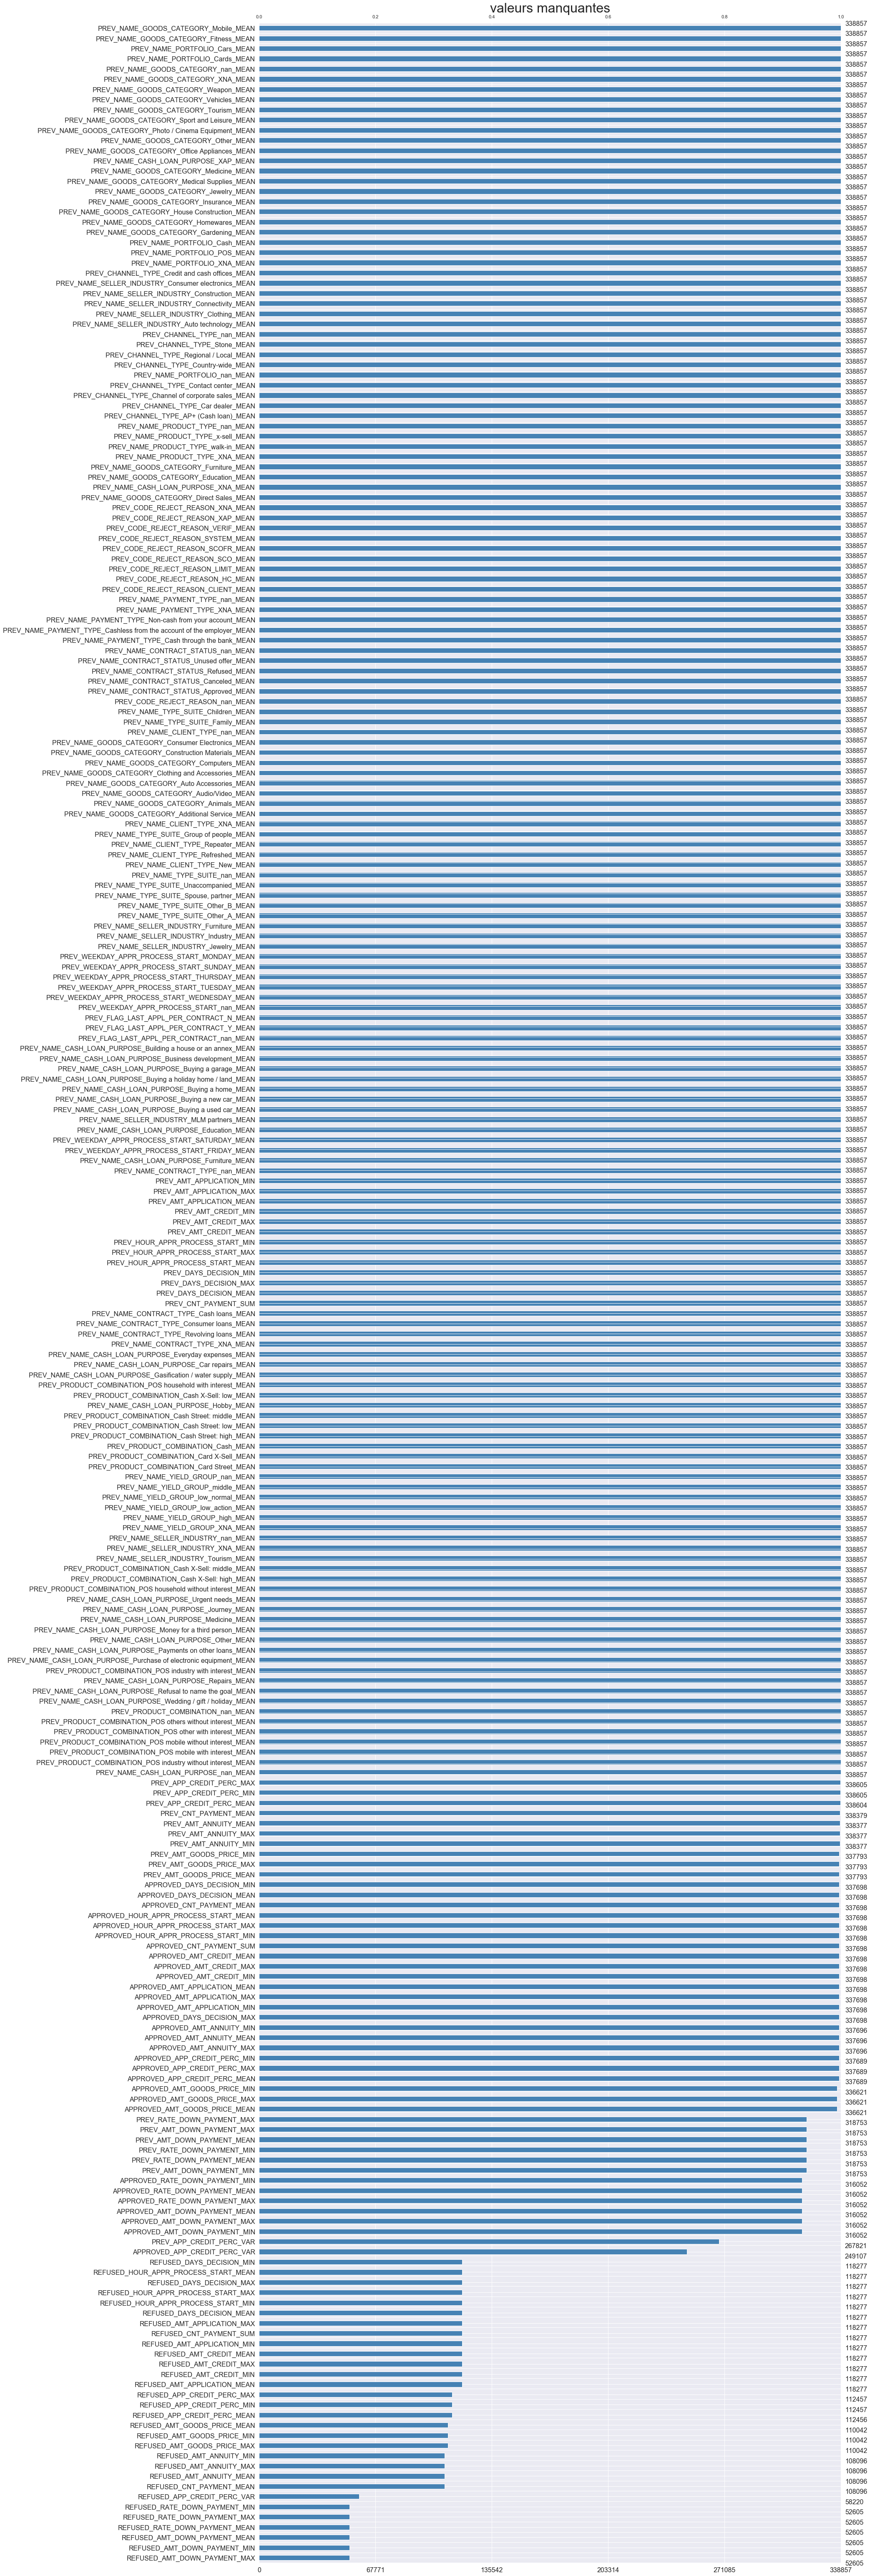

In [56]:
fig = plt.figure(figsize=(8,40))
msno.bar(prev_agg,  color="steelblue", sort="ascending")
plt.title('valeurs manquantes', size=32)
plt.show()

## POS_CASH_balance

<font color='red'>**POS_CASH_balance.csv**</font>

In [57]:
POS_CASH_balance=pd.read_csv("D:/FORMATION_DataScientist/projet_7/data/POS_CASH_balance.CSV")
print(POS_CASH_balance.shape)
print(POS_CASH_balance.columns)
print('\n Pourcentage des données manquantes par colonne dans POS_CASH_balance: \n', POS_CASH_balance.isnull().mean()*100)
POS_CASH_balance.head(2)

(10001358, 8)
Index(['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'CNT_INSTALMENT',
       'CNT_INSTALMENT_FUTURE', 'NAME_CONTRACT_STATUS', 'SK_DPD',
       'SK_DPD_DEF'],
      dtype='object')

 Pourcentage des données manquantes par colonne dans POS_CASH_balance: 
 SK_ID_PREV               0.000000
SK_ID_CURR               0.000000
MONTHS_BALANCE           0.000000
CNT_INSTALMENT           0.260675
CNT_INSTALMENT_FUTURE    0.260835
NAME_CONTRACT_STATUS     0.000000
SK_DPD                   0.000000
SK_DPD_DEF               0.000000
dtype: float64


SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0     1803195      182943             -31            48.0   
1     1715348      367990             -33            36.0   

   CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                   45.0               Active       0           0  
1                   35.0               Active       0           0

In [58]:
print('Number of non-categorical features :', POS_CASH_balance.describe().shape[1], '\n')

col= POS_CASH_balance.describe().columns
for col_ in col:
    print('\nDescription of features "', col_, '" :',HomeCredit_columns_description[HomeCredit_columns_description.Row==col_]['Description'].values)
    print('\n', len(POS_CASH_balance[col_].unique()), 'values :', POS_CASH_balance.sort_values(by=col_)[col_].unique())
    print('\n---------------------------------------------------------------------------------------------------')

POS_CASH_balance.describe()

Number of non-categorical features : 7 


Description of features " SK_ID_PREV " : []

 936325 values : [1000001 1000002 1000003 ... 2843497 2843498 2843499]

---------------------------------------------------------------------------------------------------

Description of features " SK_ID_CURR " : ['ID of loan in our sample'
 'ID of loan in our sample - one loan in our sample can have 0,1,2 or more related previous credits in credit bureau '
 'ID of loan in our sample' 'ID of loan in our sample'
 'ID of loan in our sample' 'ID of loan in our sample']

 337252 values : [100001 100002 100003 ... 456253 456254 456255]

---------------------------------------------------------------------------------------------------

Description of features " MONTHS_BALANCE " : ['Month of balance relative to application date (-1 means the freshest balance date)'
 'Month of balance relative to application date (-1 means the information to the freshest monthly snapshot, 0 means the information at applica

SK_ID_PREV    SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
count  1.000136e+07  1.000136e+07    1.000136e+07    9.975287e+06   
mean   1.903217e+06  2.784039e+05   -3.501259e+01    1.708965e+01   
std    5.358465e+05  1.027637e+05    2.606657e+01    1.199506e+01   
min    1.000001e+06  1.000010e+05   -9.600000e+01    1.000000e+00   
25%    1.434405e+06  1.895500e+05   -5.400000e+01    1.000000e+01   
50%    1.896565e+06  2.786540e+05   -2.800000e+01    1.200000e+01   
75%    2.368963e+06  3.674290e+05   -1.300000e+01    2.400000e+01   
max    2.843499e+06  4.562550e+05   -1.000000e+00    9.200000e+01   

       CNT_INSTALMENT_FUTURE        SK_DPD    SK_DPD_DEF  
count           9.975271e+06  1.000136e+07  1.000136e+07  
mean            1.048384e+01  1.160693e+01  6.544684e-01  
std             1.110906e+01  1.327140e+02  3.276249e+01  
min             0.000000e+00  0.000000e+00  0.000000e+00  
25%             3.000000e+00  0.000000e+00  0.000000e+00  
50%             7.000000e+00  0.000000e+00  0.000000e+00  
75%             1.400000e+01  0.000000e+00  0.000000e+00  
max             8.500000e+01  4.231000e+03  3.595000e+03

In [59]:
print('Number of categorical features :', POS_CASH_balance.describe(include='object').shape[1], '\n')

col= POS_CASH_balance.describe(include='object').columns
for col_ in col:
    print('\n* Feature "', col_, '" :')
    print('-------------------------------')
    print('Description of features :',HomeCredit_columns_description[HomeCredit_columns_description.Row==col_]['Description'].values)
    print('\n', len(POS_CASH_balance[col_].unique()), 'values :', POS_CASH_balance[col_].unique())
    print('\n---------------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------------')
    
POS_CASH_balance.describe(include='object')

Number of categorical features : 1 


* Feature " NAME_CONTRACT_STATUS " :
-------------------------------
Description of features : ['Contract status during the month'
 'Contract status (active signed,...) on the previous credit'
 'Contract status (approved, cancelled, ...) of previous application']

 9 values : ['Active' 'Completed' 'Signed' 'Approved' 'Returned to the store' 'Demand'
 'Canceled' 'XNA' 'Amortized debt']

---------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------


NAME_CONTRACT_STATUS
count              10001358
unique                    9
top                  Active
freq                9151119

<font color='red'>**Preprocess POS_CASH_balance.csv**</font>

* One-Hot encode des features catégorielles du POS_CASH_balance.CSV (9 features)
* POS_CASH_balance : Groupby SK_ID_CURR, Aggregation on numeric features ('max', 'mean', 'size'), Aggregation on categorical features (mean) -----> **dataframe pos_agg*
* Add feature POS_COUNT: POS_CASH_balance groupby('SK_ID_CURR').size()

--------> **dataframe pos_agg** (337252 rows × 18 columns)

In [60]:
# Preprocess POS_CASH_balance.csv
def pos_cash(pos, nan_as_category = True):
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

In [61]:
pos_agg = pos_cash(POS_CASH_balance, nan_as_category = True)

In [62]:
print(pos_agg.shape)
print(pos_agg.columns)
print('\n Pourcentage des données manquantes par colonne dans data: \n', pos_agg.isnull().mean()*100)
pos_agg.head(2)

(337252, 18)
Index(['POS_MONTHS_BALANCE_MAX', 'POS_MONTHS_BALANCE_MEAN',
       'POS_MONTHS_BALANCE_SIZE', 'POS_SK_DPD_MAX', 'POS_SK_DPD_MEAN',
       'POS_SK_DPD_DEF_MAX', 'POS_SK_DPD_DEF_MEAN',
       'POS_NAME_CONTRACT_STATUS_Active_MEAN',
       'POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN',
       'POS_NAME_CONTRACT_STATUS_Approved_MEAN',
       'POS_NAME_CONTRACT_STATUS_Canceled_MEAN',
       'POS_NAME_CONTRACT_STATUS_Completed_MEAN',
       'POS_NAME_CONTRACT_STATUS_Demand_MEAN',
       'POS_NAME_CONTRACT_STATUS_Returned to the store_MEAN',
       'POS_NAME_CONTRACT_STATUS_Signed_MEAN',
       'POS_NAME_CONTRACT_STATUS_XNA_MEAN',
       'POS_NAME_CONTRACT_STATUS_nan_MEAN', 'POS_COUNT'],
      dtype='object')

 Pourcentage des données manquantes par colonne dans data: 
 POS_MONTHS_BALANCE_MAX                                 0.0
POS_MONTHS_BALANCE_MEAN                                0.0
POS_MONTHS_BALANCE_SIZE                                0.0
POS_SK_DPD_MAX                     

POS_MONTHS_BALANCE_MAX  POS_MONTHS_BALANCE_MEAN  \
SK_ID_CURR                                                    
100001                         -53               -72.555556   
100002                          -1               -10.000000   

            POS_MONTHS_BALANCE_SIZE  POS_SK_DPD_MAX  POS_SK_DPD_MEAN  \
SK_ID_CURR                                                             
100001                            9               7         0.777778   
100002                           19               0         0.000000   

            POS_SK_DPD_DEF_MAX  POS_SK_DPD_DEF_MEAN  \
SK_ID_CURR                                            
100001                       7             0.777778   
100002                       0             0.000000   

            POS_NAME_CONTRACT_STATUS_Active_MEAN  \
SK_ID_CURR                                         
100001                                  0.777778   
100002                                  1.000000   

            POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN  \
SK_ID_CURR                                                 
100001                                               0.0   
100002                                               0.0   

            POS_NAME_CONTRACT_STATUS_Approved_MEAN  \
SK_ID_CURR                                           
100001                                         0.0   
100002                                         0.0   

            POS_NAME_CONTRACT_STATUS_Canceled_MEAN  \
SK_ID_CURR                                           
100001                                         0.0   
100002                                         0.0   

            POS_NAME_CONTRACT_STATUS_Completed_MEAN  \
SK_ID_CURR                                            
100001                                     0.222222   
100002                                     0.000000   

            POS_NAME_CONTRACT_STATUS_Demand_MEAN  \
SK_ID_CURR                                         
100001                                       0.0   
100002                                       0.0   

            POS_NAME_CONTRACT_STATUS_Returned to the store_MEAN  \
SK_ID_CURR                                                        
100001                                                    0.0     
100002                                                    0.0     

            POS_NAME_CONTRACT_STATUS_Signed_MEAN  \
SK_ID_CURR                                         
100001                                       0.0   
100002                                       0.0   

            POS_NAME_CONTRACT_STATUS_XNA_MEAN  \
SK_ID_CURR                                      
100001                                    0.0   
100002                                    0.0   

            POS_NAME_CONTRACT_STATUS_nan_MEAN  POS_COUNT  
SK_ID_CURR                                                
100001                                    0.0          9  
100002                                    0.0         19

## installments payments

<font color='red'>**installments_payments.csv**</font>

In [63]:
installments_payments=pd.read_csv("D:/FORMATION_DataScientist/projet_7/data/installments_payments.CSV")
print(installments_payments.shape)
print(installments_payments.columns)
print('\n Pourcentage des données manquantes par colonne dans POS_CASH_balance: \n', installments_payments.isnull().mean()*100)
installments_payments.head(2)

(13605401, 8)
Index(['SK_ID_PREV', 'SK_ID_CURR', 'NUM_INSTALMENT_VERSION',
       'NUM_INSTALMENT_NUMBER', 'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT',
       'AMT_INSTALMENT', 'AMT_PAYMENT'],
      dtype='object')

 Pourcentage des données manquantes par colonne dans POS_CASH_balance: 
 SK_ID_PREV                0.000000
SK_ID_CURR                0.000000
NUM_INSTALMENT_VERSION    0.000000
NUM_INSTALMENT_NUMBER     0.000000
DAYS_INSTALMENT           0.000000
DAYS_ENTRY_PAYMENT        0.021352
AMT_INSTALMENT            0.000000
AMT_PAYMENT               0.021352
dtype: float64


SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
0     1054186      161674                     1.0                      6   
1     1330831      151639                     0.0                     34   

   DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  
0          -1180.0             -1187.0        6948.360     6948.360  
1          -2156.0             -2156.0        1716.525     1716.525

In [64]:
print('Number of non-categorical features :', installments_payments.describe().shape[1], '\n')

col= installments_payments.describe().columns
for col_ in col:
    print('\nDescription of features "', col_, '" :',HomeCredit_columns_description[HomeCredit_columns_description.Row==col_]['Description'].values)
    print('\n', len(installments_payments[col_].unique()), 'values :', installments_payments.sort_values(by=col_)[col_].unique())
    print('\n---------------------------------------------------------------------------------------------------')

installments_payments.describe()

Number of non-categorical features : 8 


Description of features " SK_ID_PREV " : []

 997752 values : [1000001 1000002 1000003 ... 2843497 2843498 2843499]

---------------------------------------------------------------------------------------------------

Description of features " SK_ID_CURR " : ['ID of loan in our sample'
 'ID of loan in our sample - one loan in our sample can have 0,1,2 or more related previous credits in credit bureau '
 'ID of loan in our sample' 'ID of loan in our sample'
 'ID of loan in our sample' 'ID of loan in our sample']

 339587 values : [100001 100002 100003 ... 456253 456254 456255]

---------------------------------------------------------------------------------------------------

Description of features " NUM_INSTALMENT_VERSION " : ['Version of installment calendar (0 is for credit card) of previous credit. Change of installment version from month to month signifies that some parameter of payment calendar has changed']

 65 values : [  0.   1.   2.

SK_ID_PREV    SK_ID_CURR  NUM_INSTALMENT_VERSION  \
count  1.360540e+07  1.360540e+07            1.360540e+07   
mean   1.903365e+06  2.784449e+05            8.566373e-01   
std    5.362029e+05  1.027183e+05            1.035216e+00   
min    1.000001e+06  1.000010e+05            0.000000e+00   
25%    1.434191e+06  1.896390e+05            0.000000e+00   
50%    1.896520e+06  2.786850e+05            1.000000e+00   
75%    2.369094e+06  3.675300e+05            1.000000e+00   
max    2.843499e+06  4.562550e+05            1.780000e+02   

       NUM_INSTALMENT_NUMBER  DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  \
count           1.360540e+07     1.360540e+07        1.360250e+07   
mean            1.887090e+01    -1.042270e+03       -1.051114e+03   
std             2.666407e+01     8.009463e+02        8.005859e+02   
min             1.000000e+00    -2.922000e+03       -4.921000e+03   
25%             4.000000e+00    -1.654000e+03       -1.662000e+03   
50%             8.000000e+00    -8.180000e+02       -8.270000e+02   
75%             1.900000e+01    -3.610000e+02       -3.700000e+02   
max             2.770000e+02    -1.000000e+00       -1.000000e+00   

       AMT_INSTALMENT   AMT_PAYMENT  
count    1.360540e+07  1.360250e+07  
mean     1.705091e+04  1.723822e+04  
std      5.057025e+04  5.473578e+04  
min      0.000000e+00  0.000000e+00  
25%      4.226085e+03  3.398265e+03  
50%      8.884080e+03  8.125515e+03  
75%      1.671021e+04  1.610842e+04  
max      3.771488e+06  3.771488e+06

<font color='red'>**Preprocess installments_payments.csv**</font>

* One-Hot encode des features catégorielles du installments_payments.CSV (0 features)
* Add features : PAYMENT_PERC, PAYMENT_DIFF, DPD, DBD
* installments_payments : Groupby SK_ID_CURR, Aggregation on numeric features ('min', 'max', 'mean', 'var', 'sum) -----> **dataframe ins_agg*
* Add feature INSTAL_COUNT: installments_payments groupby('SK_ID_CURR').size()

--------> **dataframe ins_agg** (339587 rows × 26 columns)

In [65]:
# Preprocess installments_payments.csv
def installments_pay(ins, nan_as_category = True):
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

In [66]:
ins_agg = installments_pay(installments_payments, nan_as_category = True)

In [67]:
print(ins_agg.shape)
print(ins_agg.columns)
print('\n Pourcentage des données manquantes par colonne dans data: \n', ins_agg.isnull().mean()*100)
ins_agg.head(2)

(339587, 26)
Index(['INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE', 'INSTAL_DPD_MAX',
       'INSTAL_DPD_MEAN', 'INSTAL_DPD_SUM', 'INSTAL_DBD_MAX',
       'INSTAL_DBD_MEAN', 'INSTAL_DBD_SUM', 'INSTAL_PAYMENT_PERC_MAX',
       'INSTAL_PAYMENT_PERC_MEAN', 'INSTAL_PAYMENT_PERC_SUM',
       'INSTAL_PAYMENT_PERC_VAR', 'INSTAL_PAYMENT_DIFF_MAX',
       'INSTAL_PAYMENT_DIFF_MEAN', 'INSTAL_PAYMENT_DIFF_SUM',
       'INSTAL_PAYMENT_DIFF_VAR', 'INSTAL_AMT_INSTALMENT_MAX',
       'INSTAL_AMT_INSTALMENT_MEAN', 'INSTAL_AMT_INSTALMENT_SUM',
       'INSTAL_AMT_PAYMENT_MIN', 'INSTAL_AMT_PAYMENT_MAX',
       'INSTAL_AMT_PAYMENT_MEAN', 'INSTAL_AMT_PAYMENT_SUM',
       'INSTAL_DAYS_ENTRY_PAYMENT_MAX', 'INSTAL_DAYS_ENTRY_PAYMENT_MEAN',
       'INSTAL_DAYS_ENTRY_PAYMENT_SUM', 'INSTAL_COUNT'],
      dtype='object')

 Pourcentage des données manquantes par colonne dans data: 
 INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE    0.000000
INSTAL_DPD_MAX                           0.000000
INSTAL_DPD_MEAN                         

INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE  INSTAL_DPD_MAX  \
SK_ID_CURR                                                          
100001                                          2            11.0   
100002                                          2             0.0   

            INSTAL_DPD_MEAN  INSTAL_DPD_SUM  INSTAL_DBD_MAX  INSTAL_DBD_MEAN  \
SK_ID_CURR                                                                     
100001             1.571429            11.0            36.0         8.857143   
100002             0.000000             0.0            31.0        20.421053   

            INSTAL_DBD_SUM  INSTAL_PAYMENT_PERC_MAX  INSTAL_PAYMENT_PERC_MEAN  \
SK_ID_CURR                                                                      
100001                62.0                      1.0                       1.0   
100002               388.0                      1.0                       1.0   

            INSTAL_PAYMENT_PERC_SUM  ...  INSTAL_AMT_INSTALMENT_MEAN  \
SK_ID_CURR                           ...                               
100001                          7.0  ...                 5885.132143   
100002                         19.0  ...                11559.247105   

            INSTAL_AMT_INSTALMENT_SUM  INSTAL_AMT_PAYMENT_MIN  \
SK_ID_CURR                                                      
100001                      41195.925                3951.000   
100002                     219625.695                9251.775   

            INSTAL_AMT_PAYMENT_MAX  INSTAL_AMT_PAYMENT_MEAN  \
SK_ID_CURR                                                    
100001                   17397.900              5885.132143   
100002                   53093.745             11559.247105   

            INSTAL_AMT_PAYMENT_SUM  INSTAL_DAYS_ENTRY_PAYMENT_MAX  \
SK_ID_CURR                                                          
100001                   41195.925                        -1628.0   
100002                  219625.695                          -49.0   

            INSTAL_DAYS_ENTRY_PAYMENT_MEAN  INSTAL_DAYS_ENTRY_PAYMENT_SUM  \
SK_ID_CURR                                                                  
100001                        -2195.000000                       -15365.0   
100002                         -315.421053                        -5993.0   

            INSTAL_COUNT  
SK_ID_CURR                
100001                 7  
100002                19  

[2 rows x 26 columns]

## credit card balance

<font color='red'>**credit_card_balance.csv**</font>

In [68]:
credit_card_balance=pd.read_csv("D:/FORMATION_DataScientist/projet_7/data/credit_card_balance.CSV")
print(credit_card_balance.shape)
print(credit_card_balance.columns)
print('\n Pourcentage des données manquantes par colonne dans POS_CASH_balance: \n', credit_card_balance.isnull().mean()*100)
credit_card_balance.head(2)

(3840312, 23)
Index(['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'AMT_BALANCE',
       'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT',
       'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT',
       'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY',
       'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT',
       'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE',
       'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT',
       'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT',
       'CNT_INSTALMENT_MATURE_CUM', 'NAME_CONTRACT_STATUS', 'SK_DPD',
       'SK_DPD_DEF'],
      dtype='object')

 Pourcentage des données manquantes par colonne dans POS_CASH_balance: 
 SK_ID_PREV                     0.000000
SK_ID_CURR                     0.000000
MONTHS_BALANCE                 0.000000
AMT_BALANCE                    0.000000
AMT_CREDIT_LIMIT_ACTUAL        0.000000
AMT_DRAWINGS_ATM_CURRENT      19.524872
AMT_DRAWINGS_CURRENT           0.000000
AMT_DR

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0     2562384      378907              -6       56.970   
1     2582071      363914              -1    63975.555   

   AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
0                   135000                       0.0                 877.5   
1                    45000                    2250.0                2250.0   

   AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
0                         0.0                     877.5   
1                         0.0                       0.0   

   AMT_INST_MIN_REGULARITY  ...  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
0                 1700.325  ...          0.000                 0.000   
1                 2250.000  ...      64875.555             64875.555   

   CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  \
0                       0.0                     1                         0.0   
1                       1.0                     1                         0.0   

   CNT_DRAWINGS_POS_CURRENT  CNT_INSTALMENT_MATURE_CUM  NAME_CONTRACT_STATUS  \
0                       1.0                       35.0                Active   
1                       0.0                       69.0                Active   

   SK_DPD  SK_DPD_DEF  
0       0           0  
1       0           0  

[2 rows x 23 columns]

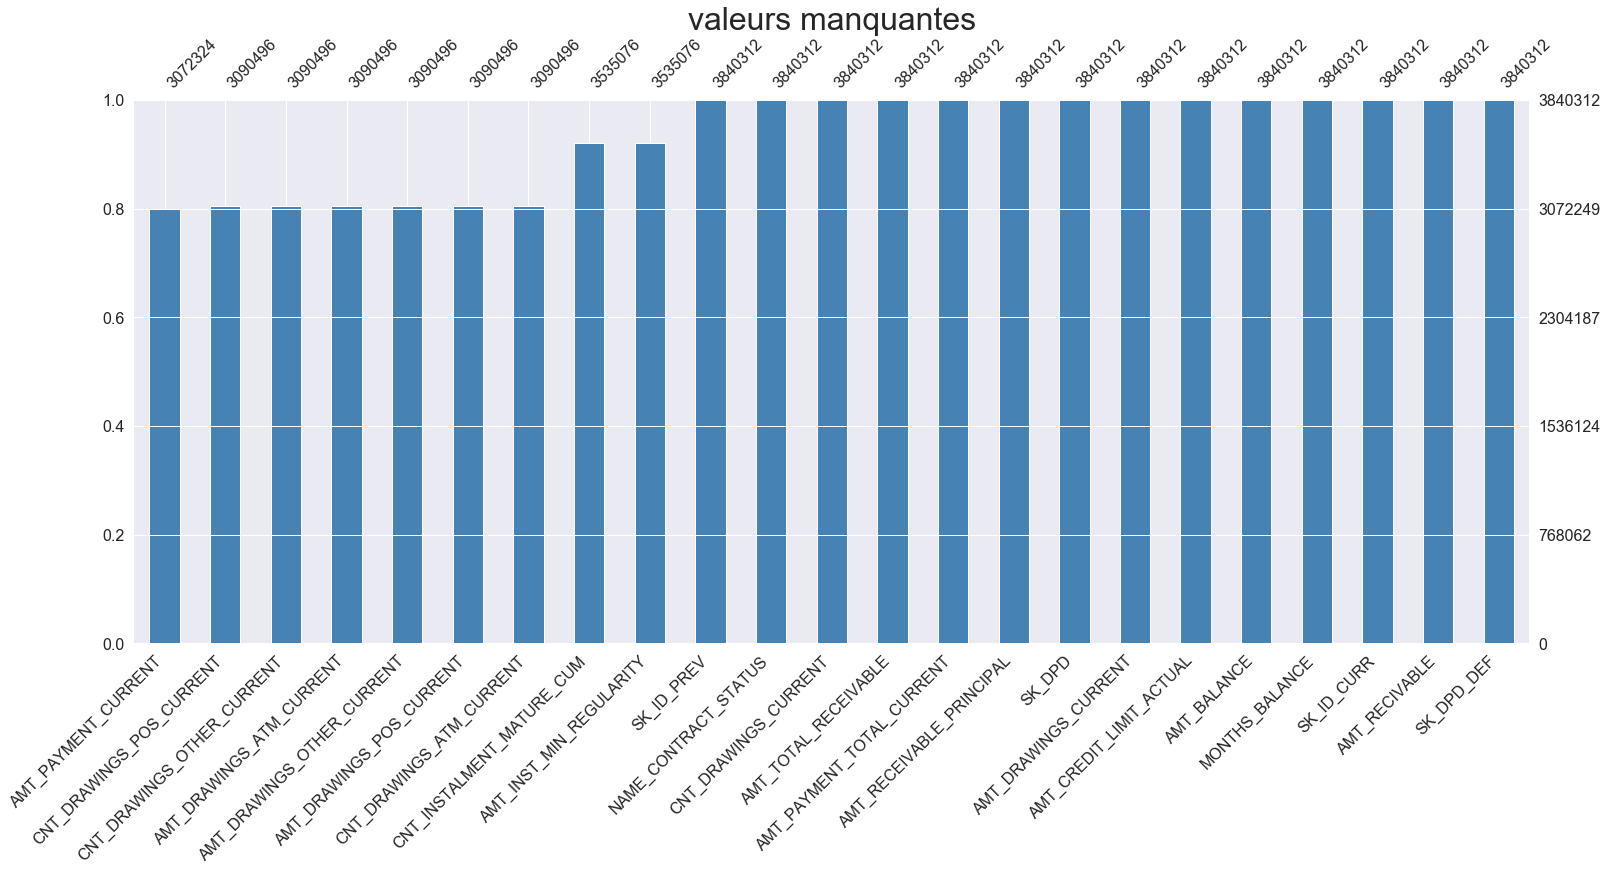

In [69]:
fig = plt.figure(figsize=(8,20))
msno.bar(credit_card_balance,  color="steelblue", sort="ascending")
plt.title('valeurs manquantes', size=32)
plt.show()

In [70]:
print('Number of non-categorical features :', credit_card_balance.describe().shape[1], '\n')

col= credit_card_balance.describe().columns
for col_ in col:
    print('\nDescription of features "', col_, '" :',HomeCredit_columns_description[HomeCredit_columns_description.Row==col_]['Description'].values)
    print('\n', len(credit_card_balance[col_].unique()), 'values :', credit_card_balance.sort_values(by=col_)[col_].unique())
    print('\n---------------------------------------------------------------------------------------------------')

credit_card_balance.describe()

Number of non-categorical features : 22 


Description of features " SK_ID_PREV " : []

 104307 values : [1000018 1000030 1000031 ... 2843478 2843493 2843496]

---------------------------------------------------------------------------------------------------

Description of features " SK_ID_CURR " : ['ID of loan in our sample'
 'ID of loan in our sample - one loan in our sample can have 0,1,2 or more related previous credits in credit bureau '
 'ID of loan in our sample' 'ID of loan in our sample'
 'ID of loan in our sample' 'ID of loan in our sample']

 103558 values : [100006 100011 100013 ... 456247 456248 456250]

---------------------------------------------------------------------------------------------------

Description of features " MONTHS_BALANCE " : ['Month of balance relative to application date (-1 means the freshest balance date)'
 'Month of balance relative to application date (-1 means the information to the freshest monthly snapshot, 0 means the information at applic


 12 values : [ 0.  1.  2.  3.  4.  5.  6.  7.  8. 10. 12. nan]

---------------------------------------------------------------------------------------------------

Description of features " CNT_DRAWINGS_POS_CURRENT " : ['Number of drawings for goods during this month on the previous credit']

 134 values : [  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 114. 115. 116. 117. 118. 119. 120. 121. 123. 124. 126. 130. 135.
 136. 140. 142. 143. 151. 162. 165.  nan]

--------

SK_ID_PREV    SK_ID_CURR  MONTHS_BALANCE   AMT_BALANCE  \
count  3.840312e+06  3.840312e+06    3.840312e+06  3.840312e+06   
mean   1.904504e+06  2.783242e+05   -3.452192e+01  5.830016e+04   
std    5.364695e+05  1.027045e+05    2.666775e+01  1.063070e+05   
min    1.000018e+06  1.000060e+05   -9.600000e+01 -4.202502e+05   
25%    1.434385e+06  1.895170e+05   -5.500000e+01  0.000000e+00   
50%    1.897122e+06  2.783960e+05   -2.800000e+01  0.000000e+00   
75%    2.369328e+06  3.675800e+05   -1.100000e+01  8.904669e+04   
max    2.843496e+06  4.562500e+05   -1.000000e+00  1.505902e+06   

       AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  \
count             3.840312e+06              3.090496e+06   
mean              1.538080e+05              5.961325e+03   
std               1.651457e+05              2.822569e+04   
min               0.000000e+00             -6.827310e+03   
25%               4.500000e+04              0.000000e+00   
50%               1.125000e+05              0.000000e+00   
75%               1.800000e+05              0.000000e+00   
max               1.350000e+06              2.115000e+06   

       AMT_DRAWINGS_CURRENT  AMT_DRAWINGS_OTHER_CURRENT  \
count          3.840312e+06                3.090496e+06   
mean           7.433388e+03                2.881696e+02   
std            3.384608e+04                8.201989e+03   
min           -6.211620e+03                0.000000e+00   
25%            0.000000e+00                0.000000e+00   
50%            0.000000e+00                0.000000e+00   
75%            0.000000e+00                0.000000e+00   
max            2.287098e+06                1.529847e+06   

       AMT_DRAWINGS_POS_CURRENT  AMT_INST_MIN_REGULARITY  ...  \
count              3.090496e+06             3.535076e+06  ...   
mean               2.968805e+03             3.540204e+03  ...   
std                2.079689e+04             5.600154e+03  ...   
min                0.000000e+00             0.000000e+00  ...   
25%                0.000000e+00             0.000000e+00  ...   
50%                0.000000e+00             0.000000e+00  ...   
75%                0.000000e+00             6.633911e+03  ...   
max                2.239274e+06             2.028820e+05  ...   

       AMT_RECEIVABLE_PRINCIPAL  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
count              3.840312e+06   3.840312e+06          3.840312e+06   
mean               5.596588e+04   5.808881e+04          5.809829e+04   
std                1.025336e+05   1.059654e+05          1.059718e+05   
min               -4.233058e+05  -4.202502e+05         -4.202502e+05   
25%                0.000000e+00   0.000000e+00          0.000000e+00   
50%                0.000000e+00   0.000000e+00          0.000000e+00   
75%                8.535924e+04   8.889949e+04          8.891451e+04   
max                1.472317e+06   1.493338e+06          1.493338e+06   

       CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  \
count              3.090496e+06          3.840312e+06   
mean               3.094490e-01          7.031439e-01   
std                1.100401e+00          3.190347e+00   
min                0.000000e+00          0.000000e+00   
25%                0.000000e+00          0.000000e+00   
50%                0.000000e+00          0.000000e+00   
75%                0.000000e+00          0.000000e+00   
max                5.100000e+01          1.650000e+02   

       CNT_DRAWINGS_OTHER_CURRENT  CNT_DRAWINGS_POS_CURRENT  \
count                3.090496e+06              3.090496e+06   
mean                 4.812496e-03              5.594791e-01   
std                  8.263861e-02              3.240649e+00   
min                  0.000000e+00              0.000000e+00   
25%                  0.000000e+00              0.000000e+00   
50%                  0.000000e+00              0.000000e+00   
75%                  0.000000e+00              0.000000e+00   
max                  1.200000e+01              1.650000e+02   

       CNT_INST

In [71]:
print('Number of categorical features :', credit_card_balance.describe(include='object').shape[1], '\n')

col= credit_card_balance.describe(include='object').columns
for col_ in col:
    print('\n* Feature "', col_, '" :')
    print('-------------------------------')
    print('Description of features :',HomeCredit_columns_description[HomeCredit_columns_description.Row==col_]['Description'].values)
    print('\n', len(credit_card_balance[col_].unique()), 'values :', credit_card_balance[col_].unique())
    print('\n---------------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------------')

credit_card_balance.describe(include='object')

Number of categorical features : 1 


* Feature " NAME_CONTRACT_STATUS " :
-------------------------------
Description of features : ['Contract status during the month'
 'Contract status (active signed,...) on the previous credit'
 'Contract status (approved, cancelled, ...) of previous application']

 7 values : ['Active' 'Completed' 'Demand' 'Signed' 'Sent proposal' 'Refused'
 'Approved']

---------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------


NAME_CONTRACT_STATUS
count               3840312
unique                    7
top                  Active
freq                3698436

<font color='red'>**Preprocess credit_card_balance.csv**</font>

* One-Hot encode des features catégorielles du credit_card_balance.CSV (1 features)
* credit_card_balance : drop SK_ID_PREV
* credit_card_balance : Groupby SK_ID_CURR, Aggregation on all features ('min', 'max', 'mean', 'var', 'sum) -----> **dataframe cc_agg*
* Add feature CC_COUNT: credit_card_balance groupby('SK_ID_CURR').size()

--------> **dataframe cc_agg** (103558 rows × 141 columns)

In [72]:
# Preprocess credit_card_balance.csv
def CC_balance(cc, nan_as_category = True):
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [73]:
cc_agg = CC_balance(credit_card_balance, nan_as_category = True)

In [74]:
print(cc_agg.shape)
print(cc_agg.columns)
print('\n Pourcentage des données manquantes par colonne dans data: \n', cc_agg.isnull().mean()*100)
cc_agg.head(2)

(103558, 141)
Index(['CC_MONTHS_BALANCE_MIN', 'CC_MONTHS_BALANCE_MAX',
       'CC_MONTHS_BALANCE_MEAN', 'CC_MONTHS_BALANCE_SUM',
       'CC_MONTHS_BALANCE_VAR', 'CC_AMT_BALANCE_MIN', 'CC_AMT_BALANCE_MAX',
       'CC_AMT_BALANCE_MEAN', 'CC_AMT_BALANCE_SUM', 'CC_AMT_BALANCE_VAR',
       ...
       'CC_NAME_CONTRACT_STATUS_Signed_MAX',
       'CC_NAME_CONTRACT_STATUS_Signed_MEAN',
       'CC_NAME_CONTRACT_STATUS_Signed_SUM',
       'CC_NAME_CONTRACT_STATUS_Signed_VAR', 'CC_NAME_CONTRACT_STATUS_nan_MIN',
       'CC_NAME_CONTRACT_STATUS_nan_MAX', 'CC_NAME_CONTRACT_STATUS_nan_MEAN',
       'CC_NAME_CONTRACT_STATUS_nan_SUM', 'CC_NAME_CONTRACT_STATUS_nan_VAR',
       'CC_COUNT'],
      dtype='object', length=141)

 Pourcentage des données manquantes par colonne dans data: 
 CC_MONTHS_BALANCE_MIN               0.000000
CC_MONTHS_BALANCE_MAX               0.000000
CC_MONTHS_BALANCE_MEAN              0.000000
CC_MONTHS_BALANCE_SUM               0.000000
CC_MONTHS_BALANCE_VAR               0.66822

CC_MONTHS_BALANCE_MIN  CC_MONTHS_BALANCE_MAX  \
SK_ID_CURR                                                 
100006                         -6                     -1   
100011                        -75                     -2   

            CC_MONTHS_BALANCE_MEAN  CC_MONTHS_BALANCE_SUM  \
SK_ID_CURR                                                  
100006                        -3.5                    -21   
100011                       -38.5                  -2849   

            CC_MONTHS_BALANCE_VAR  CC_AMT_BALANCE_MIN  CC_AMT_BALANCE_MAX  \
SK_ID_CURR                                                                  
100006                        3.5                 0.0                 0.0   
100011                      462.5                 0.0            189000.0   

            CC_AMT_BALANCE_MEAN  CC_AMT_BALANCE_SUM  CC_AMT_BALANCE_VAR  ...  \
SK_ID_CURR                                                               ...   
100006                 0.000000               0.000        0.000000e+00  ...   
100011             54482.111149         4031676.225        4.641321e+09  ...   

            CC_NAME_CONTRACT_STATUS_Signed_MAX  \
SK_ID_CURR                                       
100006                                       0   
100011                                       0   

            CC_NAME_CONTRACT_STATUS_Signed_MEAN  \
SK_ID_CURR                                        
100006                                      0.0   
100011                                      0.0   

            CC_NAME_CONTRACT_STATUS_Signed_SUM  \
SK_ID_CURR                                       
100006                                       0   
100011                                       0   

            CC_NAME_CONTRACT_STATUS_Signed_VAR  \
SK_ID_CURR                                       
100006                                     0.0   
100011                                     0.0   

            CC_NAME_CONTRACT_STATUS_nan_MIN  CC_NAME_CONTRACT_STATUS_nan_MAX  \
SK_ID_CURR                                                                     
100006                                    0                                0   
100011                                    0                                0   

            CC_NAME_CONTRACT_STATUS_nan_MEAN  CC_NAME_CONTRACT_STATUS_nan_SUM  \
SK_ID_CURR                                                                      
100006                                   0.0                                0   
100011                                   0.0                                0   

            CC_NAME_CONTRACT_STATUS_nan_VAR  CC_COUNT  
SK_ID_CURR                                             
100006                                  0.0         6  
100011                                  0.0        74  

[2 rows x 141 columns]

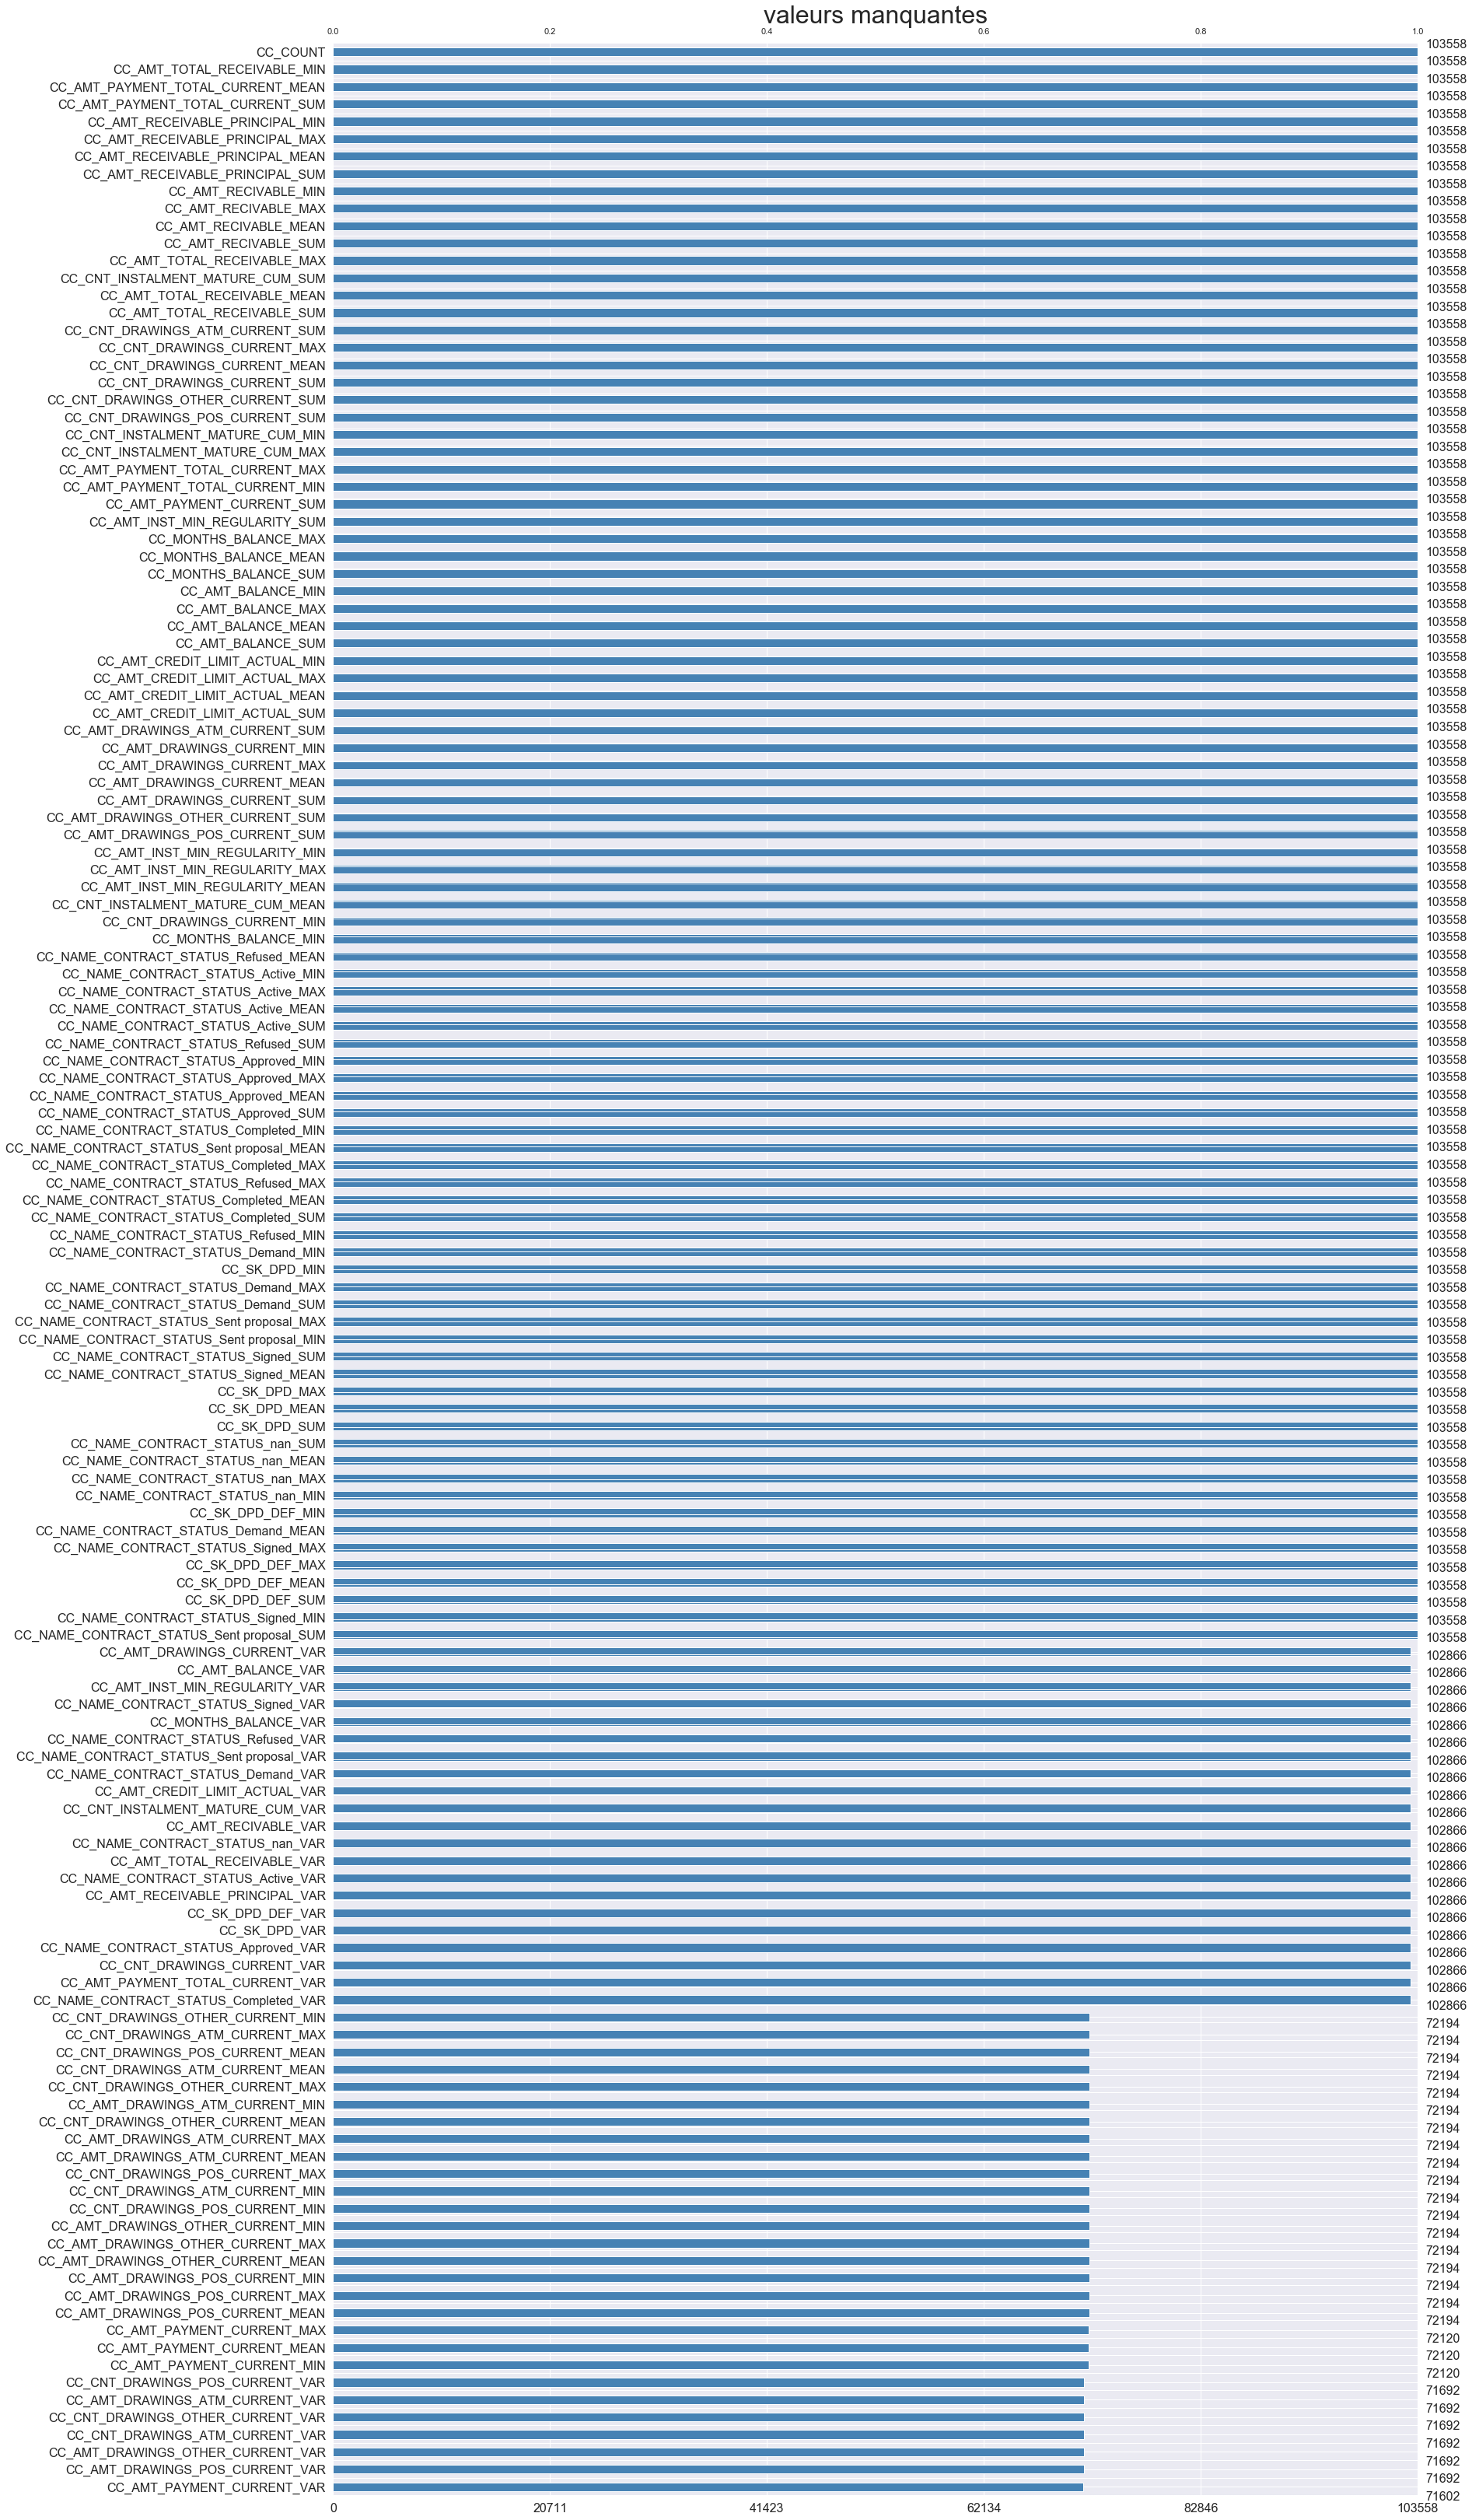

In [75]:
fig = plt.figure(figsize=(8,40))
msno.bar(cc_agg,  color="steelblue", sort="ascending")
plt.title('valeurs manquantes', size=32)
plt.show()

## Jointure des dataframe 

In [76]:
print('data_train_test :', data_train_test.shape)
print('bureau_agg :', bureau_agg.shape)
print('prev_agg :', prev_agg.shape)
print('pos_agg :', pos_agg.shape)
print('ins_agg :', ins_agg.shape)
print('cc_agg :', cc_agg.shape)

data_train_test : (356251, 248)
bureau_agg : (305811, 116)
prev_agg : (338857, 249)
pos_agg : (337252, 18)
ins_agg : (339587, 26)
cc_agg : (103558, 141)


In [77]:
data = data_train_test.copy()
# jointure à gauche avec bureau_agg
data = data.join(bureau_agg, how='left', on='SK_ID_CURR')
#del bureau_agg
#gc.collect()
# jointure à gauche avec prev_agg
data = data.join(prev_agg, how='left', on='SK_ID_CURR')
#del prev_agg
#gc.collect()
# jointure à gauche avec pos_agg
data = data.join(pos_agg, how='left', on='SK_ID_CURR')
#del pos_agg
##gc.collect()
# jointure à gauche avec ins_agg
data = data.join(ins_agg, how='left', on='SK_ID_CURR')
#del ins_agg
#gc.collect()
# jointure à gauche avec cc_agg
data = data.join(cc_agg, how='left', on='SK_ID_CURR')
##del bureau_agg
#gc.collect()

In [78]:
data.shape

(356251, 798)

In [79]:
#data.to_csv('D:/FORMATION_DataScientist/projet_7/data/data.csv')

## Valeurs manquantes

In [80]:
# Fonction pour calculer les valeurs manquantes par colonne
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [81]:
missing_values_table(data)

Missing Values  % of Total Values
REFUSED_RATE_DOWN_PAYMENT_MAX           303648               85.2
REFUSED_RATE_DOWN_PAYMENT_MIN           303648               85.2
REFUSED_RATE_DOWN_PAYMENT_MEAN          303648               85.2
REFUSED_AMT_DOWN_PAYMENT_MIN            303648               85.2
REFUSED_AMT_DOWN_PAYMENT_MAX            303648               85.2
...                                        ...                ...
PAYMENT_RATE                                36                0.0
AMT_ANNUITY                                 36                0.0
INCOME_PER_PERSON                            2                0.0
CNT_FAM_MEMBERS                              2                0.0
DAYS_LAST_PHONE_CHANGE                       1                0.0

[617 rows x 2 columns]

In [82]:
# fonction pour la suppression des colonnes ou des lignes ayant un taux de remplissage moins que t
def supression_colsligne (t, data, axis):
    columns_todrop=data.isna().sum(axis=axis)>(1-t)*data.shape[axis] 
    columns_todrop=pd.DataFrame(columns_todrop) 
    data=data.drop(columns_todrop.index[columns_todrop[0]==True], axis=1-axis) 
    return(data)

In [83]:
# appliquer la fonction ( supprimer les colonnes ayant des valeurs manquantes > 70%)
data2=supression_colsligne(0.3, data,0)
print(data2.shape)

(356251, 646)


In [84]:
# appliquer la fonction ( supprimer les colonnes ayant des valeurs manquantes > 100%)
test=supression_colsligne(1, data,0)
print(test.shape)

(356251, 181)


## Correlation between features

In [85]:
data_sample=data2.sample(n=10000)

In [86]:
# Corelation dans data
corrs =data_sample.corr()

In [87]:
corrs = corrs.sort_values('TARGET', ascending = False)

# TOP20 correlations
pd.DataFrame(corrs['TARGET'].head(20))

TARGET
TARGET                                             1.000000
PREV_NAME_CONTRACT_STATUS_Refused_MEAN             0.103136
BURO_MONTHS_BALANCE_MIN_MIN                        0.091922
BURO_DAYS_CREDIT_MEAN                              0.089803
DAYS_BIRTH                                         0.089332
BURO_CREDIT_ACTIVE_Active_MEAN                     0.082280
DAYS_EMPLOYED                                      0.080029
BURO_DAYS_CREDIT_UPDATE_MEAN                       0.078770
OCCUPATION_TYPE_Laborers                           0.076999
BURO_DAYS_CREDIT_MIN                               0.074436
OWN_CAR_AGE                                        0.073521
NAME_INCOME_TYPE_Working                           0.071571
REFUSED_DAYS_DECISION_MAX                          0.070129
BURO_STATUS_1_MEAN_MEAN                            0.069704
PREV_CODE_REJECT_REASON_HC_MEAN                    0.069452
CLOSED_MONTHS_BALANCE_MIN_MIN                      0.063808
BURO_STATUS_5_MEAN_MEAN                            0.063196
BURO_STATUS_4_MEAN_MEAN                            0.062234
PREV_CODE_REJECT_REASON_SCOFR_MEAN                 0.057417
NAME_EDUCATION_TYPE_Secondary / secondary special  0.055387

In [101]:
pd.DataFrame(corrs['TARGET'].dropna().tail(50))

TARGET
PREV_AMT_ANNUITY_MIN                    -0.037738
INSTAL_AMT_PAYMENT_MIN                  -0.037918
HOUSETYPE_MODE_block of flats           -0.038073
REGION_POPULATION_RELATIVE              -0.038321
APPROVED_RATE_DOWN_PAYMENT_MEAN         -0.038425
CLOSED_AMT_CREDIT_SUM_SUM               -0.039126
NAME_CONTRACT_TYPE_Revolving loans      -0.039201
BURO_CREDIT_TYPE_Consumer credit_MEAN   -0.040041
CLOSED_AMT_CREDIT_SUM_MAX               -0.040732
APPROVED_HOUR_APPR_PROCESS_START_MAX    -0.040733
PREV_RATE_DOWN_PAYMENT_MAX              -0.040803
REFUSED_APP_CREDIT_PERC_MIN             -0.040957
PREV_RATE_DOWN_PAYMENT_MEAN             -0.041310
ELEVATORS_AVG                           -0.041464
POS_MONTHS_BALANCE_SIZE                 -0.041692
POS_COUNT                               -0.041692
ELEVATORS_MEDI                          -0.042456
APPROVED_RATE_DOWN_PAYMENT_MAX          -0.042493
AMT_GOODS_PRICE                         -0.043462
BURO_STATUS_C_MEAN_MEAN                 -0.043887
ELEVATORS_MODE                          -0.044895
EMERGENCYSTATE_MODE_No                  -0.045623
CLOSED_MONTHS_BALANCE_MAX_MAX           -0.046707
APPROVED_AMT_ANNUITY_MEAN               -0.047060
ORGANIZATION_TYPE_XNA                   -0.047853
REFUSED_HOUR_APPR_PROCESS_START_MIN     -0.047941
REFUSED_AMT_ANNUITY_MIN                 -0.048172
FLOORSMAX_AVG                           -0.048455
FLOORSMAX_MODE                          -0.048575
FLOORSMAX_MEDI                          -0.048736
NAME_INCOME_TYPE_Pensioner              -0.048772
REFUSED_AMT_CREDIT_MIN                  -0.049237
ACTIVE_DAYS_CREDIT_VAR                  -0.049789
REFUSED_AMT_GOODS_PRICE_MIN             -0.052133
REFUSED_AMT_APPLICATION_MIN             -0.055010
CODE_GENDER                             -0.058263
CLOSED_MONTHS_BALANCE_SIZE_MEAN         -0.061062
NAME_EDUCATION_TYPE_Higher education    -0.061832
ACTIVE_MONTHS_BALANCE_SIZE_MEAN         -0.063589
FLOORSMIN_MEDI                          -0.071637
FLOORSMIN_AVG                           -0.072345
DAYS_EMPLOYED_PERC                      -0.072631
FLOORSMIN_MODE                          -0.072669
PREV_NAME_CONTRACT_STATUS_Approved_MEAN -0.082849
BURO_CREDIT_ACTIVE_Closed_MEAN          -0.085002
BURO_MONTHS_BALANCE_SIZE_MEAN           -0.087922
PREV_CODE_REJECT_REASON_XAP_MEAN        -0.094961
EXT_SOURCE_2                            -0.144563
EXT_SOURCE_1                            -0.152496
EXT_SOURCE_3                            -0.157250

# Choix des features 

## LightGBM classifier 

In [89]:
data3 = convert_types (data2, print_info=True)

Original Memory Usage: 1.51 gb.
New Memory Usage: 0.83 gb.


In [90]:
data3.shape

(356251, 646)

In [91]:
data3.describe().shape[1]

628

In [92]:
import re
data3 = data3.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [97]:
#data3.to_csv('D:/FORMATION_DataScientist/projet_7/data/data.csv')

In [93]:
# Divide in training/validation and test data
df_train = data3[data3['TARGET'].notnull()]
df_test = data3[data3['TARGET'].isnull()]
print("Starting LightGBM. Train shape: {}, test shape: {}".format(df_train.shape, df_test.shape))

Starting LightGBM. Train shape: (307507, 646), test shape: (48744, 646)


In [94]:
feats = [f for f in df_train.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]

In [95]:
# LightGBM GBDT with KFold 
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df_train, feats, num_folds):
    # Cross validation model
    folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(df_train.shape[0])
    feature_importance_df = pd.DataFrame()
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df_train[feats], df_train['TARGET'])):
        x_train, y_train = df_train[feats].iloc[train_idx], df_train['TARGET'].iloc[train_idx]
        x_test, y_test = df_train[feats].iloc[valid_idx], df_train['TARGET'].iloc[valid_idx]
        
        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

        clf.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)],
                eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

        oof_preds[valid_idx] = clf.predict_proba(x_test, num_iteration=clf.best_iteration_)[:, 1]
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(y_test, oof_preds[valid_idx])))
        del clf, x_train, y_train, x_test, y_test
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(df_train['TARGET'], oof_preds))
    
    return feature_importance_df, oof_preds, roc_auc_score(df_train['TARGET'], oof_preds)

In [102]:
feature_importance_df, oof_preds, roc_auc_score = kfold_lightgbm(df_train, feats, 5) 

D:\anaconda\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
D:\anaconda\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
D:\anaconda\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.797295	training's binary_logloss: 0.234836	valid_1's auc: 0.776086	valid_1's binary_logloss: 0.244456
[400]	training's auc: 0.821666	training's binary_logloss: 0.224759	valid_1's auc: 0.785908	valid_1's binary_logloss: 0.240448
[600]	training's auc: 0.837818	training's binary_logloss: 0.218311	valid_1's auc: 0.788756	valid_1's binary_logloss: 0.239338
[800]	training's auc: 0.851008	training's binary_logloss: 0.212889	valid_1's auc: 0.790242	valid_1's binary_logloss: 0.238807
[1000]	training's auc: 0.862329	training's binary_logloss: 0.208121	valid_1's auc: 0.790717	valid_1's binary_logloss: 0.238624
[1200]	training's auc: 0.872824	training's binary_logloss: 0.203588	valid_1's auc: 0.790837	valid_1's binary_logloss: 0.238578
Fold  1 AUC : 0.790899


D:\anaconda\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
D:\anaconda\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
D:\anaconda\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.797791	training's binary_logloss: 0.234985	valid_1's auc: 0.771709	valid_1's binary_logloss: 0.24425
[400]	training's auc: 0.822119	training's binary_logloss: 0.224989	valid_1's auc: 0.782265	valid_1's binary_logloss: 0.240155
[600]	training's auc: 0.837839	training's binary_logloss: 0.218586	valid_1's auc: 0.785781	valid_1's binary_logloss: 0.238872
[800]	training's auc: 0.850559	training's binary_logloss: 0.21332	valid_1's auc: 0.787007	valid_1's binary_logloss: 0.238378
[1000]	training's auc: 0.861903	training's binary_logloss: 0.208506	valid_1's auc: 0.787733	valid_1's binary_logloss: 0.238103
[1200]	training's auc: 0.872269	training's binary_logloss: 0.20401	valid_1's auc: 0.788118	valid_1's binary_logloss: 0.237983
[1400]	training's auc: 0.881834	training's binary_logloss: 0.199642	valid_1's auc: 0.788384	valid_1's binary_logloss: 0.237857
Fold 

D:\anaconda\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
D:\anaconda\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
D:\anaconda\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.797414	training's binary_logloss: 0.236272	valid_1's auc: 0.772099	valid_1's binary_logloss: 0.23922
[400]	training's auc: 0.821476	training's binary_logloss: 0.226219	valid_1's auc: 0.782464	valid_1's binary_logloss: 0.235262
[600]	training's auc: 0.837571	training's binary_logloss: 0.219712	valid_1's auc: 0.786014	valid_1's binary_logloss: 0.233973
[800]	training's auc: 0.850625	training's binary_logloss: 0.214321	valid_1's auc: 0.78767	valid_1's binary_logloss: 0.233439
[1000]	training's auc: 0.862073	training's binary_logloss: 0.209469	valid_1's auc: 0.78857	valid_1's binary_logloss: 0.233091
[1200]	training's auc: 0.872474	training's binary_logloss: 0.20487	valid_1's auc: 0.788963	valid_1's binary_logloss: 0.232936
[1400]	training's auc: 0.881701	training's binary_logloss: 0.200543	valid_1's auc: 0.789251	valid_1's binary_logloss: 0.232787
[1600]

D:\anaconda\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
D:\anaconda\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
D:\anaconda\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.797977	training's binary_logloss: 0.235181	valid_1's auc: 0.77134	valid_1's binary_logloss: 0.24333
[400]	training's auc: 0.82167	training's binary_logloss: 0.225236	valid_1's auc: 0.781824	valid_1's binary_logloss: 0.239212
[600]	training's auc: 0.837445	training's binary_logloss: 0.218758	valid_1's auc: 0.785805	valid_1's binary_logloss: 0.237795
[800]	training's auc: 0.85013	training's binary_logloss: 0.213562	valid_1's auc: 0.787583	valid_1's binary_logloss: 0.237199
[1000]	training's auc: 0.861221	training's binary_logloss: 0.208855	valid_1's auc: 0.788706	valid_1's binary_logloss: 0.236824
[1200]	training's auc: 0.871904	training's binary_logloss: 0.204242	valid_1's auc: 0.789218	valid_1's binary_logloss: 0.236645
[1400]	training's auc: 0.88128	training's binary_logloss: 0.199933	valid_1's auc: 0.789511	valid_1's binary_logloss: 0.236531
[1600]	

D:\anaconda\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
D:\anaconda\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
D:\anaconda\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.797241	training's binary_logloss: 0.235495	valid_1's auc: 0.774451	valid_1's binary_logloss: 0.242222
[400]	training's auc: 0.821295	training's binary_logloss: 0.225518	valid_1's auc: 0.784926	valid_1's binary_logloss: 0.238051
[600]	training's auc: 0.83723	training's binary_logloss: 0.219035	valid_1's auc: 0.788072	valid_1's binary_logloss: 0.236839
[800]	training's auc: 0.850907	training's binary_logloss: 0.213509	valid_1's auc: 0.789531	valid_1's binary_logloss: 0.236263
[1000]	training's auc: 0.862319	training's binary_logloss: 0.208705	valid_1's auc: 0.79018	valid_1's binary_logloss: 0.235995
[1200]	training's auc: 0.872695	training's binary_logloss: 0.204197	valid_1's auc: 0.790516	valid_1's binary_logloss: 0.235831
[1400]	training's auc: 0.881937	training's binary_logloss: 0.199952	valid_1's auc: 0.790573	valid_1's binary_logloss: 0.2358
Fold  

##  Importance features

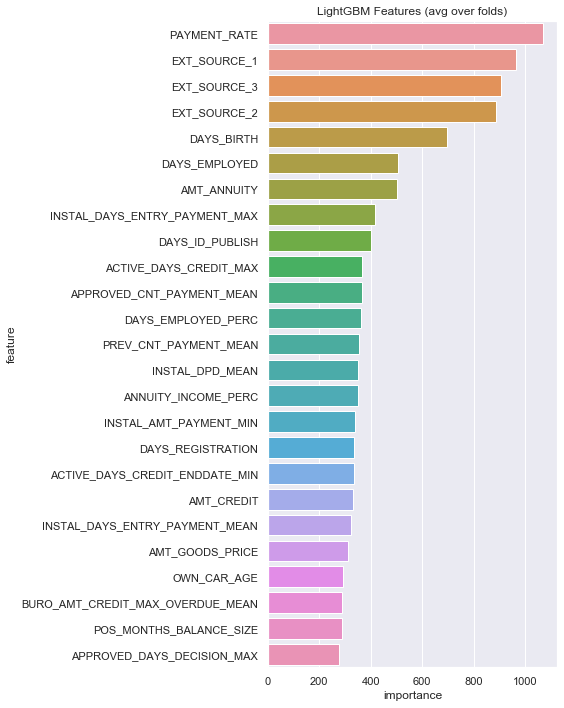

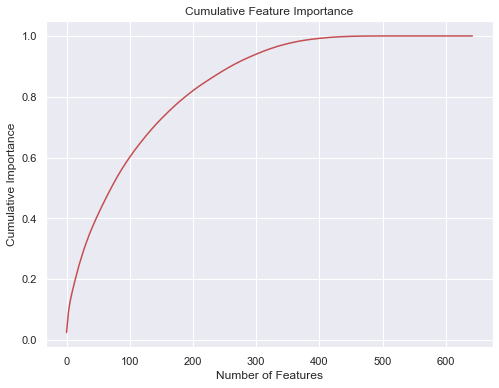

261 features required for 0.90 of cumulative importance


index                                          feature  importance  \
0      384                                     PAYMENT_RATE      1071.6   
1      181                                     EXT_SOURCE_1       965.4   
2      183                                     EXT_SOURCE_3       907.8   
3      182                                     EXT_SOURCE_2       886.8   
4      165                                       DAYS_BIRTH       695.6   
..     ...                                              ...         ...   
638    491                 PREV_NAME_CONTRACT_TYPE_XNA_MEAN         0.0   
639    492                 PREV_NAME_CONTRACT_TYPE_nan_MEAN         0.0   
640    493  PREV_NAME_GOODS_CATEGORY_AdditionalService_MEAN         0.0   
641    494            PREV_NAME_GOODS_CATEGORY_Animals_MEAN         0.0   
642    502          PREV_NAME_GOODS_CATEGORY_Education_MEAN         0.0   

     importance_normalized  cumulative_importance  
0                 0.025351               0.025351  
1                 0.022838               0.048189  
2                 0.021476               0.069664  
3                 0.020979               0.090643  
4                 0.016456               0.107099  
..                     ...                    ...  
638               0.000000               1.000000  
639               0.000000               1.000000  
640               0.000000               1.000000  
641               0.000000               1.000000  
642               0.000000               1.000000  

[643 rows x 5 columns]

In [103]:
# plot feature importance
feature_importance_df2 = feature_importance_df.groupby('feature')['feature', 'importance'].mean().reset_index()
feature_importance_df2 = display_importances(feature_importance_df2)
feature_importance_df2

In [107]:
# Threshold for cumulative importance
threshold = 0.9

# Extract the features to keep
features_to_keep = list(feature_importance_df2[feature_importance_df2['cumulative_importance'] < threshold]['feature'])
features_to_keep.append('SK_ID_CURR')
features_to_keep.append('TARGET')

# Create new datasets with smaller features
df_train_impfeatures = df_train[features_to_keep]
df_test_impfeatures = df_test[features_to_keep]

In [ ]:
#df_train_impfeatures.to_csv('D:/FORMATION_DataScientist/projet_7/data/df_train_impfeatures.csv')

In [108]:
df_train_impfeatures.shape

(307507, 262)

In [105]:
df_oof_preds = pd.DataFrame({'TARGET':df_train['TARGET'], 'PREDICTION':oof_preds})
df_oof_preds = df_oof_preds[['TARGET', 'PREDICTION']]

# Imputation des données manquantes

imputation par la valeur médian

In [121]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    #df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

In [133]:
df_train_impfeatures = clean_dataset(df_train_impfeatures)

In [134]:
df_train_impfeatures.shape

(307506, 262)

In [135]:
feats = [f for f in df_train_impfeatures.columns if f not in ['TARGET']]

In [136]:
print('Missing values in df_train_impfeatures: ', sum(df_train_impfeatures.isnull().sum()))
print('Missing values in df_test_impfeatures: ', sum(df_test_impfeatures.isnull().sum()))

Missing values in df_train_impfeatures:  14445847
Missing values in df_test_impfeatures:  1797131


In [137]:
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
df_train_impfeatures.iloc[:,:] = imputer.fit_transform(df_train_impfeatures)

In [142]:
df_train_impfeatures

PAYMENT_RATE  EXT_SOURCE_1  EXT_SOURCE_3  EXT_SOURCE_2  DAYS_BIRTH  \
0           0.060749      0.083037      0.139376      0.262949     -9461.0   
1           0.027598      0.311267      0.535276      0.622246    -16765.0   
2           0.050000      0.505998      0.729567      0.555912    -19046.0   
3           0.094941      0.505998      0.535276      0.650442    -19005.0   
4           0.042623      0.505998      0.535276      0.322738    -19932.0   
...              ...           ...           ...           ...         ...   
307506      0.108198      0.145570      0.535276      0.681632     -9327.0   
307507      0.044524      0.505998      0.535276      0.115992    -20775.0   
307508      0.044239      0.744026      0.218859      0.535722    -14966.0   
307509      0.054592      0.505998      0.661024      0.514163    -11961.0   
307510      0.072767      0.734460      0.113922      0.708569    -16856.0   

        DAYS_EMPLOYED  AMT_ANNUITY  INSTAL_DAYS_ENTRY_PAYMENT_MAX  \
0              -637.0      24700.5                          -49.0   
1             -1188.0      35698.5                         -544.0   
2              -225.0       6750.0                         -727.0   
3             -3039.0      29686.5                          -12.0   
4             -3038.0      21865.5                          -14.0   
...               ...          ...                            ...   
307506         -236.0      27558.0                          -38.0   
307507        -1648.0      12001.5                        -2327.0   
307508        -7921.0      29979.0                        -1738.0   
307509        -4786.0      20205.0                          -18.0   
307510        -1262.0      49117.5                          -76.0   

        DAYS_ID_PUBLISH  ACTIVE_DAYS_CREDIT_MAX  ...  \
0               -2120.0                  -103.0  ...   
1                -291.0                  -606.0  ...   
2               -2531.0                  -258.0  ...   
3               -2437.0                  -258.0  ...   
4               -3458.0                  -258.0  ...   
...                 ...                     ...  ...   
307506          -1982.0                  -258.0  ...   
307507          -4090.0                  -258.0  ...   
307508          -5150.0                  -713.0  ...   
307509           -931.0                  -258.0  ...   
307510           -410.0                  -363.0  ...   

        YEARS_BEGINEXPLUATATION_AVG  LIVINGAREA_MODE  \
0                            0.9722           0.0198   
1                            0.9851           0.0554   
2                            0.9816           0.0731   
3                            0.9816           0.0731   
4                            0.9816           0.0731   
...                             ...              ...   
307506                       0.9876           0.0853   
307507                       0.9727           0.0267   
307508                       0.9816           0.9667   
307509                       0.9771           0.0063   
307510                       0.9881           0.0824   

        APPROVED_RATE_DOWN_PAYMENT_MIN  \
0                             0.000000   
1                             0.000000   
2                             0.212008   
3                             0.108994   
4                             0.100143   
...                                ...   
307506                        0.000000   
307507                        0.062443   
307508                        0.104349   
307509                        0.000000   
307510                        0.000000   

        PREV_CHANNEL_TYPE_Channelofcorporatesales_MEAN  \
0                                                  0.0   
1                                                  0.0   
2                                                  0.0   
3                                                  0.0   
4                                                  0.0   
...                                        

In [144]:
print('Missing values in df_train_impfeatures: ', sum(df_train_impfeatures.isnull().sum()))

Missing values in df_train_impfeatures:  0


In [145]:
df_train_impfeatures.to_csv('D:/FORMATION_DataScientist/projet_7/data_train/df_train_impfeatures.csv')

test

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
# Oversample and plot imbalanced dataset with SMOTE
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot
from numpy import where

y = df_train['TARGET']
X = df_train[feats]
# summarize class distribution
counter = Counter(y)
print(counter)
# transform the dataset
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = where(y == label)[0]
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()

In [ ]:
import collections
collections.Counter(df_train['TARGET'])
collections.Counter(y)

In [ ]:
# Set the threshold
threshold = 0.9

# Empty dictionary to hold correlated variables
above_threshold_vars = {}

# For each column, record the variables that are above the threshold
for col in corrs:
    above_threshold_vars[col] = list(corrs.index[corrs[col] > threshold])
    
above_threshold_vars

In [ ]:
# Track columns to remove and columns already examined
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

# Iterate through columns and correlated columns
for key, value in above_threshold_vars.items():
    # Keep track of columns already examined
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            # Only want to remove one in a pair
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)
            
cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))

In [ ]:
df_corrs_removed = data2.drop(columns = cols_to_remove)
df_corrs_removed

In [ ]:
#lightGBM without kfold

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df_train[feats], df_train['TARGET'], test_size = 0.25, random_state = i)

In [ ]:
# LightGBM parameters found by Bayesian optimization
clf = LGBMClassifier(n_estimators=10000, learning_rate=0.02, num_leaves=34, colsample_bytree=0.9497036, 
                     subsample=0.8715623, max_depth=8, reg_alpha=0.041545473, reg_lambda=0.0735294, 
                     min_split_gain=0.0222415, min_child_weight=39.3259775)

In [ ]:
clf.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)], eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)  

In [ ]:
feature_importances = np.zeros(df_train.shape[1])
feature_importances = clf.feature_importances_

feature_importances = pd.DataFrame({'feature': list(x_train.columns),
                                    'importance': feature_importances}).sort_values('importance', ascending = False)
feature_importances

In [ ]:
feature_importances = display_importances(feature_importances)
feature_importances

In [ ]:
oof_preds_test = clf.predict_proba(x_test, num_iteration=clf.best_iteration_)[:, 1]


In [ ]:
roc_auc_score(y_test, oof_preds_test) TypeError: 'numpy.float64' object is not callable

In [ ]:
len(oof_preds_test)

In [ ]:
df_train.shape

In [ ]:
folds = KFold(n_splits= 5, shuffle=True, random_state=1001)

In [ ]:
folds.split(df_train[feats], df_train['TARGET'])

In [ ]:
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df_train[feats], df_train['TARGET'])):
    print('1:', train_idx.shape)
    print('\n1:', valid_idx)
    print('---------------------------------------------')